In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "06"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-xtree-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-xtree-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-xtree-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
!ls ../data/processed/dsv02

test.parquet  train.parquet


In [6]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [7]:
input_feats = train.columns.tolist()
len(input_feats)

1308

In [8]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [9]:
model_params = {
    'boosting':'dart',
    'extra_trees':True,
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.2,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [10]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=5000,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [11]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################


######################################## training model 1/5 ########################################


[50]	valid_0's amex_metric: 0.749495	valid_0's recall_at4: 0.598923	valid_0's norm_gini: 0.900067


[100]	valid_0's amex_metric: 0.760116	valid_0's recall_at4: 0.614786	valid_0's norm_gini: 0.905445


[150]	valid_0's amex_metric: 0.763177	valid_0's recall_at4: 0.618699	valid_0's norm_gini: 0.907654


[200]	valid_0's amex_metric: 0.765906	valid_0's recall_at4: 0.62278	valid_0's norm_gini: 0.909032


[250]	valid_0's amex_metric: 0.76931	valid_0's recall_at4: 0.627535	valid_0's norm_gini: 0.911085


[300]	valid_0's amex_metric: 0.771053	valid_0's recall_at4: 0.629471	valid_0's norm_gini: 0.912635


[350]	valid_0's amex_metric: 0.773165	valid_0's recall_at4: 0.632542	valid_0's norm_gini: 0.913787


[400]	valid_0's amex_metric: 0.775251	valid_0's recall_at4: 0.636035	valid_0's norm_gini: 0.914468


[450]	valid_0's amex_metric: 0.777107	valid_0's recall_at4: 0.638601	valid_0's norm_gini: 0.915613


[500]	valid_0's amex_metric: 0.779425	valid_0's recall_at4: 0.641925	valid_0's norm_gini: 0.916925


[550]	valid_0's amex_metric: 0.781922	valid_0's recall_at4: 0.645797	valid_0's norm_gini: 0.918048


[600]	valid_0's amex_metric: 0.782997	valid_0's recall_at4: 0.647101	valid_0's norm_gini: 0.918894


[650]	valid_0's amex_metric: 0.784528	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.91943


[700]	valid_0's amex_metric: 0.785056	valid_0's recall_at4: 0.650173	valid_0's norm_gini: 0.91994


[750]	valid_0's amex_metric: 0.785386	valid_0's recall_at4: 0.650425	valid_0's norm_gini: 0.920347


[800]	valid_0's amex_metric: 0.787382	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.920721


[850]	valid_0's amex_metric: 0.787772	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.921037


[900]	valid_0's amex_metric: 0.78869	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.9214


[950]	valid_0's amex_metric: 0.789607	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.92172


[1000]	valid_0's amex_metric: 0.790573	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.922053


[1050]	valid_0's amex_metric: 0.791509	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922452


[1100]	valid_0's amex_metric: 0.791498	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.922683


[1150]	valid_0's amex_metric: 0.791877	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.922851


[1200]	valid_0's amex_metric: 0.792942	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.922962


[1250]	valid_0's amex_metric: 0.793205	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923194


[1300]	valid_0's amex_metric: 0.793111	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.923258


[1350]	valid_0's amex_metric: 0.793417	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923365


[1400]	valid_0's amex_metric: 0.793506	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923502


[1450]	valid_0's amex_metric: 0.793687	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.923654


[1500]	valid_0's amex_metric: 0.794284	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923796


[1550]	valid_0's amex_metric: 0.795118	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.923948


[1600]	valid_0's amex_metric: 0.795508	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.924098


[1650]	valid_0's amex_metric: 0.795377	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.924214


[1700]	valid_0's amex_metric: 0.79581	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.92428


[1750]	valid_0's amex_metric: 0.796142	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.924397


[1800]	valid_0's amex_metric: 0.796065	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.924495


[1850]	valid_0's amex_metric: 0.797041	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.924554


[1900]	valid_0's amex_metric: 0.796774	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.924609


[1950]	valid_0's amex_metric: 0.796946	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.924658


[2000]	valid_0's amex_metric: 0.796378	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924743


[2050]	valid_0's amex_metric: 0.79701	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924828


[2100]	valid_0's amex_metric: 0.797122	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924927


[2150]	valid_0's amex_metric: 0.797062	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.925016


[2200]	valid_0's amex_metric: 0.797453	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925083


[2250]	valid_0's amex_metric: 0.797537	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925125


[2300]	valid_0's amex_metric: 0.797744	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.92516


[2350]	valid_0's amex_metric: 0.797904	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925186


[2400]	valid_0's amex_metric: 0.798456	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925238


[2450]	valid_0's amex_metric: 0.798419	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.92529


[2500]	valid_0's amex_metric: 0.798838	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925328


[2550]	valid_0's amex_metric: 0.798768	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925356


[2600]	valid_0's amex_metric: 0.798913	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.925394


[2650]	valid_0's amex_metric: 0.798653	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925422


[2700]	valid_0's amex_metric: 0.799012	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925466


[2750]	valid_0's amex_metric: 0.79913	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.925492


[2800]	valid_0's amex_metric: 0.799291	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.925519


[2850]	valid_0's amex_metric: 0.799082	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.925565


[2900]	valid_0's amex_metric: 0.799317	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925614


[2950]	valid_0's amex_metric: 0.79935	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.925638


[3000]	valid_0's amex_metric: 0.799956	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.925672


[3050]	valid_0's amex_metric: 0.79945	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.925669


[3100]	valid_0's amex_metric: 0.799613	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.9257


[3150]	valid_0's amex_metric: 0.799629	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.925732


[3200]	valid_0's amex_metric: 0.799241	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.925757


[3250]	valid_0's amex_metric: 0.798965	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925793


[3300]	valid_0's amex_metric: 0.799403	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.925828


[3350]	valid_0's amex_metric: 0.799435	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.925808


[3400]	valid_0's amex_metric: 0.798937	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925821


[3450]	valid_0's amex_metric: 0.799208	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925859


[3500]	valid_0's amex_metric: 0.799174	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925874


[3550]	valid_0's amex_metric: 0.798802	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925887


[3600]	valid_0's amex_metric: 0.799108	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925912


[3650]	valid_0's amex_metric: 0.799104	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925945


[3700]	valid_0's amex_metric: 0.798952	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925936


[3750]	valid_0's amex_metric: 0.798953	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925937


[3800]	valid_0's amex_metric: 0.799524	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.925943


[3850]	valid_0's amex_metric: 0.799646	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.925978


[3900]	valid_0's amex_metric: 0.799518	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.925974


[3950]	valid_0's amex_metric: 0.79993	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.925998


[4000]	valid_0's amex_metric: 0.799926	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.925991


[4050]	valid_0's amex_metric: 0.799648	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926022


[4100]	valid_0's amex_metric: 0.799679	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926044


[4150]	valid_0's amex_metric: 0.799559	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926055


[4200]	valid_0's amex_metric: 0.799547	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.926073


[4250]	valid_0's amex_metric: 0.799466	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.92608


[4300]	valid_0's amex_metric: 0.799434	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.926101


[4350]	valid_0's amex_metric: 0.799339	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92612


[4400]	valid_0's amex_metric: 0.799574	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.926127


[4450]	valid_0's amex_metric: 0.799521	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926147


[4500]	valid_0's amex_metric: 0.799067	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.926165


[4550]	valid_0's amex_metric: 0.799367	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926177


[4600]	valid_0's amex_metric: 0.799122	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.926192


[4650]	valid_0's amex_metric: 0.798982	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926206


[4700]	valid_0's amex_metric: 0.799107	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926204


[4750]	valid_0's amex_metric: 0.799344	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926216


[4800]	valid_0's amex_metric: 0.799841	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.92624


[4850]	valid_0's amex_metric: 0.799696	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926245


[4900]	valid_0's amex_metric: 0.799881	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.92628


[4950]	valid_0's amex_metric: 0.799648	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.926277


[5000]	valid_0's amex_metric: 0.799945	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.92628


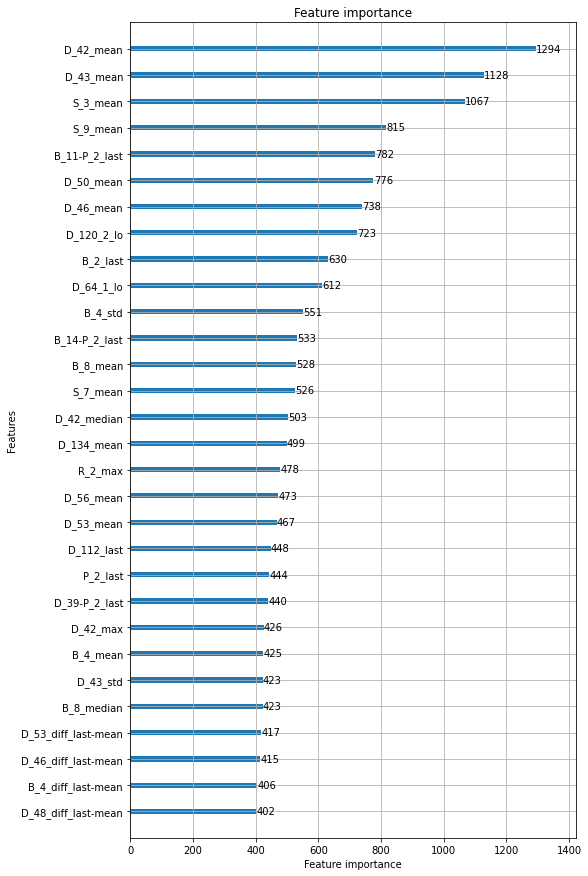

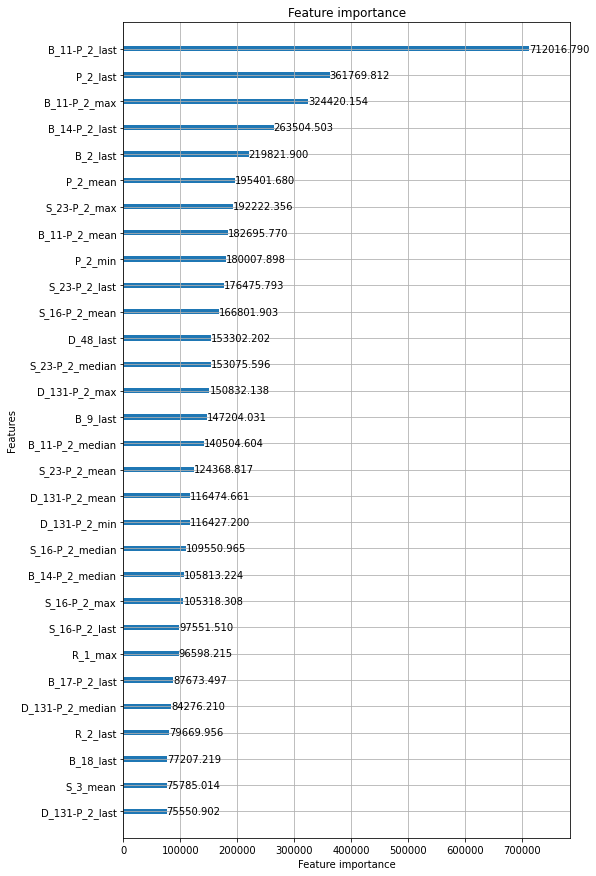

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.745462	valid_0's recall_at4: 0.591644	valid_0's norm_gini: 0.89928


[100]	valid_0's amex_metric: 0.755154	valid_0's recall_at4: 0.606202	valid_0's norm_gini: 0.904107


[150]	valid_0's amex_metric: 0.759704	valid_0's recall_at4: 0.612682	valid_0's norm_gini: 0.906726


[200]	valid_0's amex_metric: 0.763459	valid_0's recall_at4: 0.618194	valid_0's norm_gini: 0.908724


[250]	valid_0's amex_metric: 0.76704	valid_0's recall_at4: 0.623664	valid_0's norm_gini: 0.910415


[300]	valid_0's amex_metric: 0.770344	valid_0's recall_at4: 0.628671	valid_0's norm_gini: 0.912016


[350]	valid_0's amex_metric: 0.771481	valid_0's recall_at4: 0.63006	valid_0's norm_gini: 0.912903


[400]	valid_0's amex_metric: 0.772383	valid_0's recall_at4: 0.631112	valid_0's norm_gini: 0.913654


[450]	valid_0's amex_metric: 0.775874	valid_0's recall_at4: 0.636834	valid_0's norm_gini: 0.914913


[500]	valid_0's amex_metric: 0.777783	valid_0's recall_at4: 0.639527	valid_0's norm_gini: 0.916038


[550]	valid_0's amex_metric: 0.780257	valid_0's recall_at4: 0.643356	valid_0's norm_gini: 0.917157


[600]	valid_0's amex_metric: 0.782681	valid_0's recall_at4: 0.647353	valid_0's norm_gini: 0.918009


[650]	valid_0's amex_metric: 0.783862	valid_0's recall_at4: 0.649205	valid_0's norm_gini: 0.918519


[700]	valid_0's amex_metric: 0.78538	valid_0's recall_at4: 0.651771	valid_0's norm_gini: 0.918989


[750]	valid_0's amex_metric: 0.78584	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.919404


[800]	valid_0's amex_metric: 0.78681	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.919786


[850]	valid_0's amex_metric: 0.787705	valid_0's recall_at4: 0.655348	valid_0's norm_gini: 0.920062


[900]	valid_0's amex_metric: 0.788473	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.920379


[950]	valid_0's amex_metric: 0.789875	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.920741


[1000]	valid_0's amex_metric: 0.788988	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.921113


[1050]	valid_0's amex_metric: 0.790233	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.921457


[1100]	valid_0's amex_metric: 0.790955	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.921724


[1150]	valid_0's amex_metric: 0.791678	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.921991


[1200]	valid_0's amex_metric: 0.792254	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.922175


[1250]	valid_0's amex_metric: 0.792301	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.922396


[1300]	valid_0's amex_metric: 0.791895	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.922425


[1350]	valid_0's amex_metric: 0.792088	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922558


[1400]	valid_0's amex_metric: 0.792886	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.922767


[1450]	valid_0's amex_metric: 0.7934	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.922911


[1500]	valid_0's amex_metric: 0.79314	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923064


[1550]	valid_0's amex_metric: 0.793717	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.923208


[1600]	valid_0's amex_metric: 0.7939	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.923322


[1650]	valid_0's amex_metric: 0.793742	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.923425


[1700]	valid_0's amex_metric: 0.793636	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.923508


[1750]	valid_0's amex_metric: 0.794163	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.923637


[1800]	valid_0's amex_metric: 0.794522	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.923766


[1850]	valid_0's amex_metric: 0.794589	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.923901


[1900]	valid_0's amex_metric: 0.795011	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.923945


[1950]	valid_0's amex_metric: 0.794929	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.923992


[2000]	valid_0's amex_metric: 0.795339	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.924096


[2050]	valid_0's amex_metric: 0.795633	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.92422


[2100]	valid_0's amex_metric: 0.795472	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.92432


[2150]	valid_0's amex_metric: 0.79581	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.924406


[2200]	valid_0's amex_metric: 0.795854	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.924452


[2250]	valid_0's amex_metric: 0.796582	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.92452


[2300]	valid_0's amex_metric: 0.796785	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.924547


[2350]	valid_0's amex_metric: 0.796548	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.924578


[2400]	valid_0's amex_metric: 0.796908	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924624


[2450]	valid_0's amex_metric: 0.796937	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924684


[2500]	valid_0's amex_metric: 0.796969	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924746


[2550]	valid_0's amex_metric: 0.796885	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.92479


[2600]	valid_0's amex_metric: 0.796801	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.924832


[2650]	valid_0's amex_metric: 0.79734	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.924899


[2700]	valid_0's amex_metric: 0.797145	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924973


[2750]	valid_0's amex_metric: 0.797076	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925002


[2800]	valid_0's amex_metric: 0.797313	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925056


[2850]	valid_0's amex_metric: 0.797003	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925109


[2900]	valid_0's amex_metric: 0.79723	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.9251


[2950]	valid_0's amex_metric: 0.797153	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925115


[3000]	valid_0's amex_metric: 0.797039	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.925139


[3050]	valid_0's amex_metric: 0.796779	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.925167


[3100]	valid_0's amex_metric: 0.796922	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.925199


[3150]	valid_0's amex_metric: 0.797367	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925248


[3200]	valid_0's amex_metric: 0.797221	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925292


[3250]	valid_0's amex_metric: 0.79747	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.925329


[3300]	valid_0's amex_metric: 0.797841	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925355


[3350]	valid_0's amex_metric: 0.797562	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925385


[3400]	valid_0's amex_metric: 0.797696	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.9254


[3450]	valid_0's amex_metric: 0.797554	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.925412


[3500]	valid_0's amex_metric: 0.797691	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925433


[3550]	valid_0's amex_metric: 0.797651	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.925437


[3600]	valid_0's amex_metric: 0.797752	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925471


[3650]	valid_0's amex_metric: 0.797996	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.925495


[3700]	valid_0's amex_metric: 0.797885	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925528


[3750]	valid_0's amex_metric: 0.798149	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.92555


[3800]	valid_0's amex_metric: 0.798275	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925592


[3850]	valid_0's amex_metric: 0.798244	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925613


[3900]	valid_0's amex_metric: 0.798249	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925624


[3950]	valid_0's amex_metric: 0.798534	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925647


[4000]	valid_0's amex_metric: 0.798644	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925656


[4050]	valid_0's amex_metric: 0.798235	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925681


[4100]	valid_0's amex_metric: 0.798489	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.925682


[4150]	valid_0's amex_metric: 0.798204	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925702


[4200]	valid_0's amex_metric: 0.798295	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925715


[4250]	valid_0's amex_metric: 0.799002	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925742


[4300]	valid_0's amex_metric: 0.798838	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925749


[4350]	valid_0's amex_metric: 0.79897	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925762


[4400]	valid_0's amex_metric: 0.798983	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925788


[4450]	valid_0's amex_metric: 0.798869	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925812


[4500]	valid_0's amex_metric: 0.799174	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925832


[4550]	valid_0's amex_metric: 0.79895	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925847


[4600]	valid_0's amex_metric: 0.799037	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925853


[4650]	valid_0's amex_metric: 0.79885	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925858


[4700]	valid_0's amex_metric: 0.79848	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925875


[4750]	valid_0's amex_metric: 0.799148	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925907


[4800]	valid_0's amex_metric: 0.799231	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925946


[4850]	valid_0's amex_metric: 0.799261	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925965


[4900]	valid_0's amex_metric: 0.799147	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925989


[4950]	valid_0's amex_metric: 0.79945	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926006


[5000]	valid_0's amex_metric: 0.799292	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926028


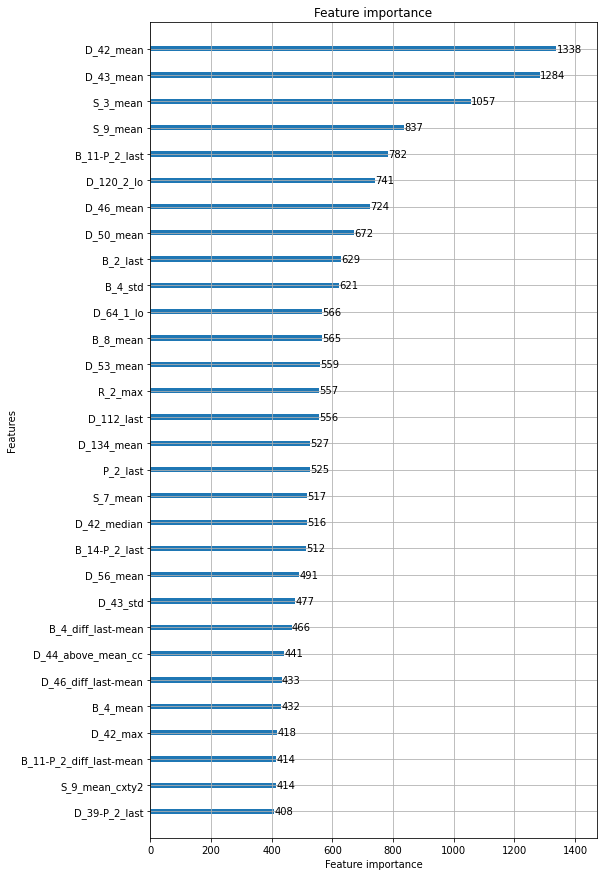

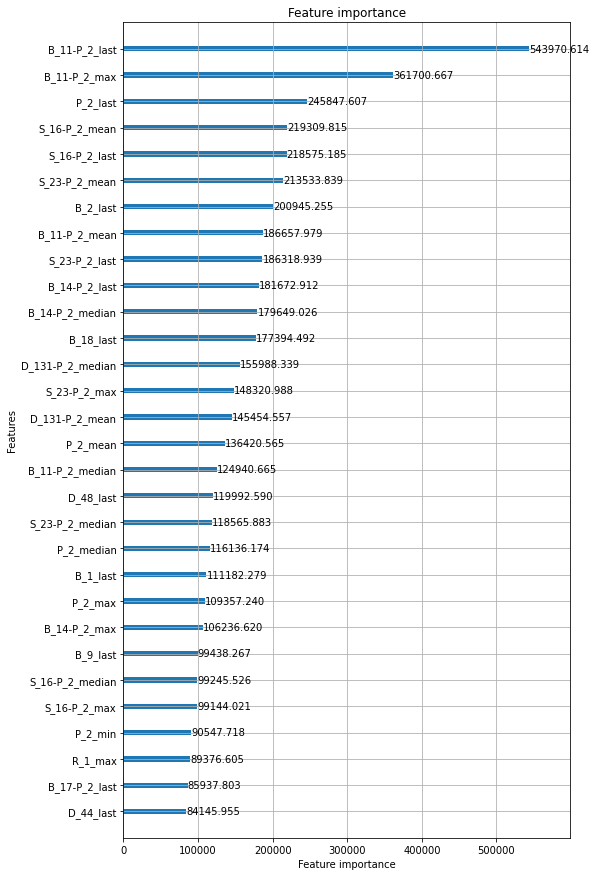

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.742038	valid_0's recall_at4: 0.586005	valid_0's norm_gini: 0.898071


[100]	valid_0's amex_metric: 0.751861	valid_0's recall_at4: 0.600438	valid_0's norm_gini: 0.903285


[150]	valid_0's amex_metric: 0.75629	valid_0's recall_at4: 0.607002	valid_0's norm_gini: 0.905578


[200]	valid_0's amex_metric: 0.75943	valid_0's recall_at4: 0.61184	valid_0's norm_gini: 0.907019


[250]	valid_0's amex_metric: 0.764536	valid_0's recall_at4: 0.619709	valid_0's norm_gini: 0.909363


[300]	valid_0's amex_metric: 0.767378	valid_0's recall_at4: 0.623874	valid_0's norm_gini: 0.910881


[350]	valid_0's amex_metric: 0.768187	valid_0's recall_at4: 0.624674	valid_0's norm_gini: 0.911699


[400]	valid_0's amex_metric: 0.769302	valid_0's recall_at4: 0.626189	valid_0's norm_gini: 0.912416


[450]	valid_0's amex_metric: 0.771321	valid_0's recall_at4: 0.629134	valid_0's norm_gini: 0.913508


[500]	valid_0's amex_metric: 0.773886	valid_0's recall_at4: 0.633005	valid_0's norm_gini: 0.914767


[550]	valid_0's amex_metric: 0.776891	valid_0's recall_at4: 0.637928	valid_0's norm_gini: 0.915854


[600]	valid_0's amex_metric: 0.77757	valid_0's recall_at4: 0.638349	valid_0's norm_gini: 0.916791


[650]	valid_0's amex_metric: 0.778528	valid_0's recall_at4: 0.63978	valid_0's norm_gini: 0.917276


[700]	valid_0's amex_metric: 0.78013	valid_0's recall_at4: 0.642472	valid_0's norm_gini: 0.917788


[750]	valid_0's amex_metric: 0.781424	valid_0's recall_at4: 0.64466	valid_0's norm_gini: 0.918187


[800]	valid_0's amex_metric: 0.781897	valid_0's recall_at4: 0.645292	valid_0's norm_gini: 0.918503


[850]	valid_0's amex_metric: 0.782607	valid_0's recall_at4: 0.646386	valid_0's norm_gini: 0.918828


[900]	valid_0's amex_metric: 0.783268	valid_0's recall_at4: 0.647395	valid_0's norm_gini: 0.919141


[950]	valid_0's amex_metric: 0.78388	valid_0's recall_at4: 0.648279	valid_0's norm_gini: 0.919481


[1000]	valid_0's amex_metric: 0.784161	valid_0's recall_at4: 0.648574	valid_0's norm_gini: 0.919749


[1050]	valid_0's amex_metric: 0.785869	valid_0's recall_at4: 0.651603	valid_0's norm_gini: 0.920135


[1100]	valid_0's amex_metric: 0.785585	valid_0's recall_at4: 0.650762	valid_0's norm_gini: 0.920408


[1150]	valid_0's amex_metric: 0.785975	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.9206


[1200]	valid_0's amex_metric: 0.786018	valid_0's recall_at4: 0.651267	valid_0's norm_gini: 0.92077


[1250]	valid_0's amex_metric: 0.785855	valid_0's recall_at4: 0.650762	valid_0's norm_gini: 0.920948


[1300]	valid_0's amex_metric: 0.786301	valid_0's recall_at4: 0.651603	valid_0's norm_gini: 0.920999


[1350]	valid_0's amex_metric: 0.786089	valid_0's recall_at4: 0.651056	valid_0's norm_gini: 0.921122


[1400]	valid_0's amex_metric: 0.786484	valid_0's recall_at4: 0.651687	valid_0's norm_gini: 0.92128


[1450]	valid_0's amex_metric: 0.786869	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.921378


[1500]	valid_0's amex_metric: 0.787235	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.921478


[1550]	valid_0's amex_metric: 0.788172	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.92167


[1600]	valid_0's amex_metric: 0.788239	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.921804


[1650]	valid_0's amex_metric: 0.787294	valid_0's recall_at4: 0.652697	valid_0's norm_gini: 0.921891


[1700]	valid_0's amex_metric: 0.788315	valid_0's recall_at4: 0.654633	valid_0's norm_gini: 0.921997


[1750]	valid_0's amex_metric: 0.788499	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.922113


[1800]	valid_0's amex_metric: 0.788789	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.922189


[1850]	valid_0's amex_metric: 0.788602	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.922276


[1900]	valid_0's amex_metric: 0.788739	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.922341


[1950]	valid_0's amex_metric: 0.789701	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.922413


[2000]	valid_0's amex_metric: 0.789708	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.922553


[2050]	valid_0's amex_metric: 0.790161	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.922702


[2100]	valid_0's amex_metric: 0.790404	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.92281


[2150]	valid_0's amex_metric: 0.791189	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.922906


[2200]	valid_0's amex_metric: 0.791316	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.922992


[2250]	valid_0's amex_metric: 0.79094	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.923041


[2300]	valid_0's amex_metric: 0.791427	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.923088


[2350]	valid_0's amex_metric: 0.791475	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.923142


[2400]	valid_0's amex_metric: 0.791324	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.923176


[2450]	valid_0's amex_metric: 0.791175	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.923215


[2500]	valid_0's amex_metric: 0.791404	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.923253


[2550]	valid_0's amex_metric: 0.79142	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923326


[2600]	valid_0's amex_metric: 0.791808	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.923388


[2650]	valid_0's amex_metric: 0.792036	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923423


[2700]	valid_0's amex_metric: 0.792796	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.92347


[2750]	valid_0's amex_metric: 0.792414	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.923504


[2800]	valid_0's amex_metric: 0.792771	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.923546


[2850]	valid_0's amex_metric: 0.793023	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923587


[2900]	valid_0's amex_metric: 0.792959	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.923627


[2950]	valid_0's amex_metric: 0.793114	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.923643


[3000]	valid_0's amex_metric: 0.792794	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923676


[3050]	valid_0's amex_metric: 0.792959	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.923711


[3100]	valid_0's amex_metric: 0.79314	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.923737


[3150]	valid_0's amex_metric: 0.793111	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923762


[3200]	valid_0's amex_metric: 0.793264	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.923774


[3250]	valid_0's amex_metric: 0.793187	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.923831


[3300]	valid_0's amex_metric: 0.793397	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.923871


[3350]	valid_0's amex_metric: 0.793656	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.923885


[3400]	valid_0's amex_metric: 0.794206	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.923892


[3450]	valid_0's amex_metric: 0.793798	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.923917


[3500]	valid_0's amex_metric: 0.794186	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.923935


[3550]	valid_0's amex_metric: 0.79391	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.92393


[3600]	valid_0's amex_metric: 0.793923	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.923956


[3650]	valid_0's amex_metric: 0.794067	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923993


[3700]	valid_0's amex_metric: 0.794082	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924021


[3750]	valid_0's amex_metric: 0.794008	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924041


[3800]	valid_0's amex_metric: 0.793959	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.92407


[3850]	valid_0's amex_metric: 0.793536	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924109


[3900]	valid_0's amex_metric: 0.793943	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924122


[3950]	valid_0's amex_metric: 0.793947	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.92413


[4000]	valid_0's amex_metric: 0.79441	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.924132


[4050]	valid_0's amex_metric: 0.793555	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924146


[4100]	valid_0's amex_metric: 0.793502	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.924165


[4150]	valid_0's amex_metric: 0.793865	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924178


[4200]	valid_0's amex_metric: 0.793832	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924196


[4250]	valid_0's amex_metric: 0.794383	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924204


[4300]	valid_0's amex_metric: 0.79418	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924218


[4350]	valid_0's amex_metric: 0.794175	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924208


[4400]	valid_0's amex_metric: 0.793552	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924223


[4450]	valid_0's amex_metric: 0.793765	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.92423


[4500]	valid_0's amex_metric: 0.793684	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924236


[4550]	valid_0's amex_metric: 0.793686	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924241


[4600]	valid_0's amex_metric: 0.793562	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924244


[4650]	valid_0's amex_metric: 0.793602	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924241


[4700]	valid_0's amex_metric: 0.793683	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924235


[4750]	valid_0's amex_metric: 0.793597	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.924273


[4800]	valid_0's amex_metric: 0.793361	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924262


[4850]	valid_0's amex_metric: 0.793706	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924279


[4900]	valid_0's amex_metric: 0.793923	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924294


[4950]	valid_0's amex_metric: 0.79386	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.924293


[5000]	valid_0's amex_metric: 0.794036	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924309


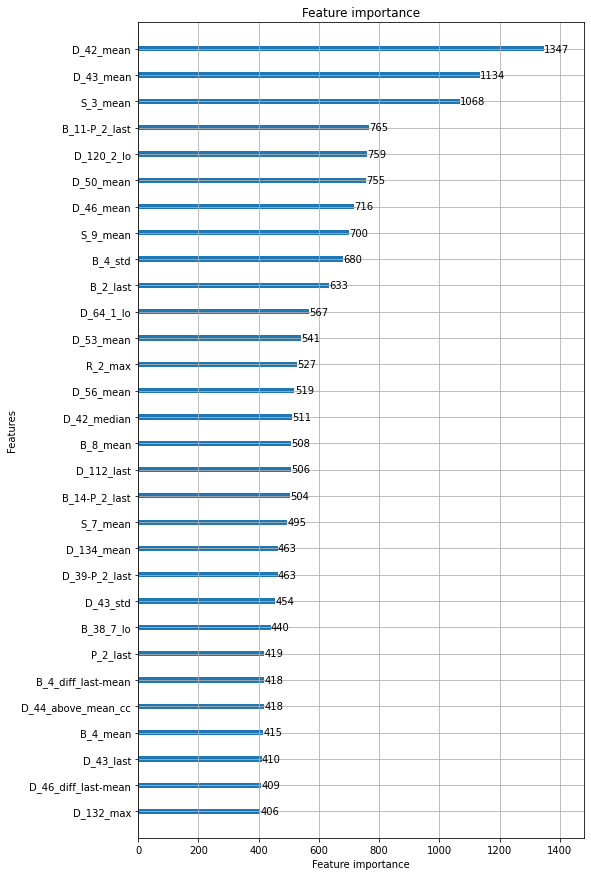

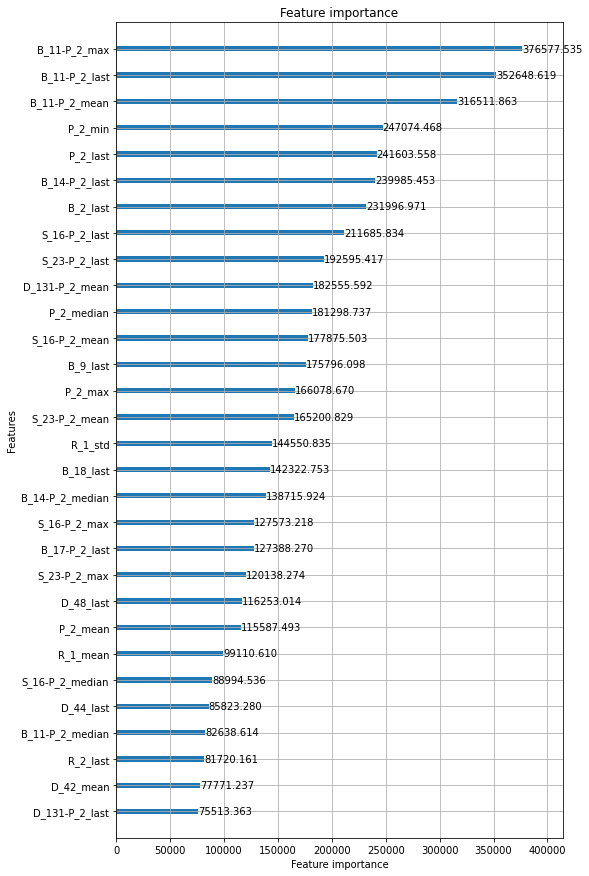

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.742134	valid_0's recall_at4: 0.58725	valid_0's norm_gini: 0.897018


[100]	valid_0's amex_metric: 0.752683	valid_0's recall_at4: 0.602567	valid_0's norm_gini: 0.902799


[150]	valid_0's amex_metric: 0.75813	valid_0's recall_at4: 0.611025	valid_0's norm_gini: 0.905236


[200]	valid_0's amex_metric: 0.760809	valid_0's recall_at4: 0.614349	valid_0's norm_gini: 0.90727


[250]	valid_0's amex_metric: 0.764136	valid_0's recall_at4: 0.61923	valid_0's norm_gini: 0.909043


[300]	valid_0's amex_metric: 0.766501	valid_0's recall_at4: 0.622428	valid_0's norm_gini: 0.910574


[350]	valid_0's amex_metric: 0.768511	valid_0's recall_at4: 0.625458	valid_0's norm_gini: 0.911564


[400]	valid_0's amex_metric: 0.770431	valid_0's recall_at4: 0.628614	valid_0's norm_gini: 0.912249


[450]	valid_0's amex_metric: 0.772105	valid_0's recall_at4: 0.630844	valid_0's norm_gini: 0.913366


[500]	valid_0's amex_metric: 0.774022	valid_0's recall_at4: 0.633453	valid_0's norm_gini: 0.914592


[550]	valid_0's amex_metric: 0.77662	valid_0's recall_at4: 0.63745	valid_0's norm_gini: 0.91579


[600]	valid_0's amex_metric: 0.77702	valid_0's recall_at4: 0.637366	valid_0's norm_gini: 0.916675


[650]	valid_0's amex_metric: 0.778352	valid_0's recall_at4: 0.63947	valid_0's norm_gini: 0.917234


[700]	valid_0's amex_metric: 0.77877	valid_0's recall_at4: 0.639764	valid_0's norm_gini: 0.917775


[750]	valid_0's amex_metric: 0.779828	valid_0's recall_at4: 0.64149	valid_0's norm_gini: 0.918167


[800]	valid_0's amex_metric: 0.780841	valid_0's recall_at4: 0.643131	valid_0's norm_gini: 0.918551


[850]	valid_0's amex_metric: 0.782323	valid_0's recall_at4: 0.645782	valid_0's norm_gini: 0.918865


[900]	valid_0's amex_metric: 0.782099	valid_0's recall_at4: 0.645024	valid_0's norm_gini: 0.919173


[950]	valid_0's amex_metric: 0.783044	valid_0's recall_at4: 0.646497	valid_0's norm_gini: 0.919591


[1000]	valid_0's amex_metric: 0.783695	valid_0's recall_at4: 0.647507	valid_0's norm_gini: 0.919884


[1050]	valid_0's amex_metric: 0.784915	valid_0's recall_at4: 0.649527	valid_0's norm_gini: 0.920304


[1100]	valid_0's amex_metric: 0.785622	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.92054


[1150]	valid_0's amex_metric: 0.785295	valid_0's recall_at4: 0.649821	valid_0's norm_gini: 0.920769


[1200]	valid_0's amex_metric: 0.785821	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.920938


[1250]	valid_0's amex_metric: 0.785731	valid_0's recall_at4: 0.650284	valid_0's norm_gini: 0.921178


[1300]	valid_0's amex_metric: 0.786198	valid_0's recall_at4: 0.651168	valid_0's norm_gini: 0.921228


[1350]	valid_0's amex_metric: 0.786505	valid_0's recall_at4: 0.651631	valid_0's norm_gini: 0.92138


[1400]	valid_0's amex_metric: 0.787087	valid_0's recall_at4: 0.652556	valid_0's norm_gini: 0.921618


[1450]	valid_0's amex_metric: 0.786546	valid_0's recall_at4: 0.651294	valid_0's norm_gini: 0.921799


[1500]	valid_0's amex_metric: 0.787502	valid_0's recall_at4: 0.653061	valid_0's norm_gini: 0.921943


[1550]	valid_0's amex_metric: 0.787276	valid_0's recall_at4: 0.652472	valid_0's norm_gini: 0.92208


[1600]	valid_0's amex_metric: 0.78808	valid_0's recall_at4: 0.653945	valid_0's norm_gini: 0.922215


[1650]	valid_0's amex_metric: 0.78847	valid_0's recall_at4: 0.654618	valid_0's norm_gini: 0.922322


[1700]	valid_0's amex_metric: 0.788564	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.922426


[1750]	valid_0's amex_metric: 0.789047	valid_0's recall_at4: 0.655544	valid_0's norm_gini: 0.922549


[1800]	valid_0's amex_metric: 0.789206	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.922657


[1850]	valid_0's amex_metric: 0.789354	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.922743


[1900]	valid_0's amex_metric: 0.789383	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.922801


[1950]	valid_0's amex_metric: 0.789496	valid_0's recall_at4: 0.656133	valid_0's norm_gini: 0.922859


[2000]	valid_0's amex_metric: 0.789571	valid_0's recall_at4: 0.656133	valid_0's norm_gini: 0.923009


[2050]	valid_0's amex_metric: 0.789302	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.923144


[2100]	valid_0's amex_metric: 0.789695	valid_0's recall_at4: 0.656133	valid_0's norm_gini: 0.923257


[2150]	valid_0's amex_metric: 0.790214	valid_0's recall_at4: 0.657059	valid_0's norm_gini: 0.92337


[2200]	valid_0's amex_metric: 0.790384	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.923414


[2250]	valid_0's amex_metric: 0.790432	valid_0's recall_at4: 0.657395	valid_0's norm_gini: 0.923468


[2300]	valid_0's amex_metric: 0.790163	valid_0's recall_at4: 0.656806	valid_0's norm_gini: 0.92352


[2350]	valid_0's amex_metric: 0.790082	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.923569


[2400]	valid_0's amex_metric: 0.790403	valid_0's recall_at4: 0.657185	valid_0's norm_gini: 0.923621


[2450]	valid_0's amex_metric: 0.790862	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923655


[2500]	valid_0's amex_metric: 0.790597	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.923714


[2550]	valid_0's amex_metric: 0.790633	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.923787


[2600]	valid_0's amex_metric: 0.790956	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923844


[2650]	valid_0's amex_metric: 0.791127	valid_0's recall_at4: 0.658363	valid_0's norm_gini: 0.92389


[2700]	valid_0's amex_metric: 0.790876	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.923937


[2750]	valid_0's amex_metric: 0.790792	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.923979


[2800]	valid_0's amex_metric: 0.790617	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.924007


[2850]	valid_0's amex_metric: 0.790782	valid_0's recall_at4: 0.657522	valid_0's norm_gini: 0.924042


[2900]	valid_0's amex_metric: 0.791185	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.924091


[2950]	valid_0's amex_metric: 0.791464	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924102


[3000]	valid_0's amex_metric: 0.791204	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.924128


[3050]	valid_0's amex_metric: 0.791097	valid_0's recall_at4: 0.658027	valid_0's norm_gini: 0.924167


[3100]	valid_0's amex_metric: 0.791246	valid_0's recall_at4: 0.658321	valid_0's norm_gini: 0.92417


[3150]	valid_0's amex_metric: 0.791456	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.924212


[3200]	valid_0's amex_metric: 0.791746	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.924245


[3250]	valid_0's amex_metric: 0.791513	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.924285


[3300]	valid_0's amex_metric: 0.791543	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.924302


[3350]	valid_0's amex_metric: 0.791661	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.924327


[3400]	valid_0's amex_metric: 0.791987	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.924348


[3450]	valid_0's amex_metric: 0.790999	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.92435


[3500]	valid_0's amex_metric: 0.790915	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.924392


[3550]	valid_0's amex_metric: 0.790906	valid_0's recall_at4: 0.657395	valid_0's norm_gini: 0.924417


[3600]	valid_0's amex_metric: 0.790967	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.924455


[3650]	valid_0's amex_metric: 0.791475	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.924502


[3700]	valid_0's amex_metric: 0.791801	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.924525


[3750]	valid_0's amex_metric: 0.791686	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924546


[3800]	valid_0's amex_metric: 0.791403	valid_0's recall_at4: 0.658237	valid_0's norm_gini: 0.92457


[3850]	valid_0's amex_metric: 0.791936	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.924626


[3900]	valid_0's amex_metric: 0.792174	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.924639


[3950]	valid_0's amex_metric: 0.791777	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924643


[4000]	valid_0's amex_metric: 0.792242	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.924647


[4050]	valid_0's amex_metric: 0.792391	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.924694


[4100]	valid_0's amex_metric: 0.792332	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924702


[4150]	valid_0's amex_metric: 0.792025	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.92472


[4200]	valid_0's amex_metric: 0.792073	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.924731


[4250]	valid_0's amex_metric: 0.791809	valid_0's recall_at4: 0.658868	valid_0's norm_gini: 0.924749


[4300]	valid_0's amex_metric: 0.791946	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.92477


[4350]	valid_0's amex_metric: 0.791973	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.924783


[4400]	valid_0's amex_metric: 0.791967	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924814


[4450]	valid_0's amex_metric: 0.792071	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.924811


[4500]	valid_0's amex_metric: 0.792063	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.924838


[4550]	valid_0's amex_metric: 0.791877	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924843


[4600]	valid_0's amex_metric: 0.791881	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924851


[4650]	valid_0's amex_metric: 0.791797	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.924853


[4700]	valid_0's amex_metric: 0.791984	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924848


[4750]	valid_0's amex_metric: 0.792518	valid_0's recall_at4: 0.660173	valid_0's norm_gini: 0.924864


[4800]	valid_0's amex_metric: 0.792404	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.924887


[4850]	valid_0's amex_metric: 0.792523	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.924915


[4900]	valid_0's amex_metric: 0.792442	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924923


[4950]	valid_0's amex_metric: 0.792365	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.924935


[5000]	valid_0's amex_metric: 0.792455	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924947


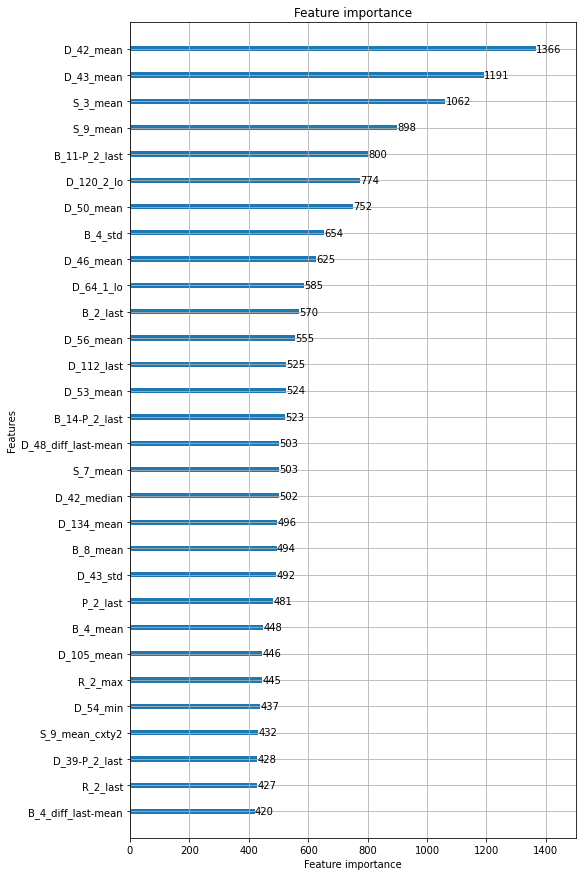

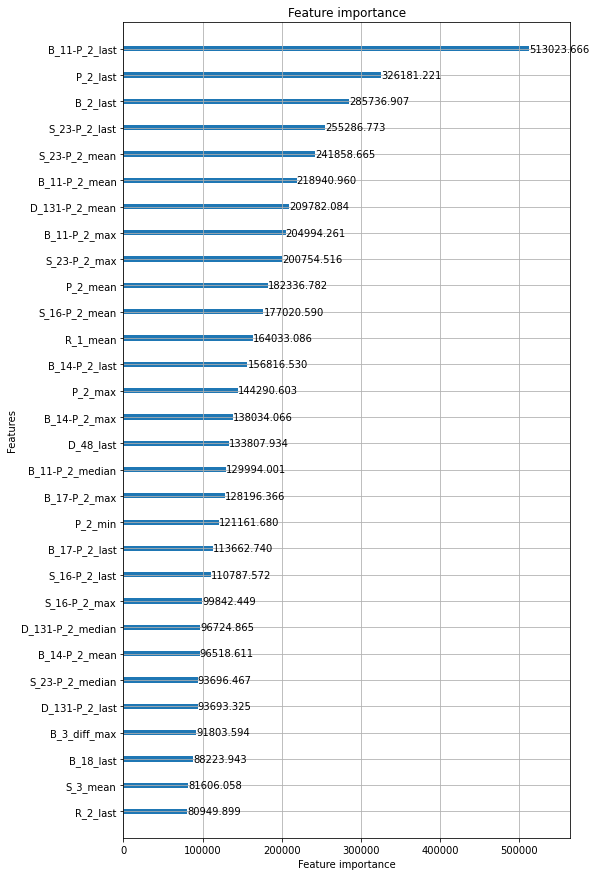

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.751968	valid_0's recall_at4: 0.602819	valid_0's norm_gini: 0.901117


[100]	valid_0's amex_metric: 0.761302	valid_0's recall_at4: 0.616158	valid_0's norm_gini: 0.906446


[150]	valid_0's amex_metric: 0.766398	valid_0's recall_at4: 0.624069	valid_0's norm_gini: 0.908727


[200]	valid_0's amex_metric: 0.76907	valid_0's recall_at4: 0.627604	valid_0's norm_gini: 0.910536


[250]	valid_0's amex_metric: 0.771786	valid_0's recall_at4: 0.631349	valid_0's norm_gini: 0.912224


[300]	valid_0's amex_metric: 0.775207	valid_0's recall_at4: 0.636693	valid_0's norm_gini: 0.913721


[350]	valid_0's amex_metric: 0.776661	valid_0's recall_at4: 0.638586	valid_0's norm_gini: 0.914735


[400]	valid_0's amex_metric: 0.779305	valid_0's recall_at4: 0.64292	valid_0's norm_gini: 0.915689


[450]	valid_0's amex_metric: 0.781052	valid_0's recall_at4: 0.645277	valid_0's norm_gini: 0.916827


[500]	valid_0's amex_metric: 0.783991	valid_0's recall_at4: 0.649863	valid_0's norm_gini: 0.918119


[550]	valid_0's amex_metric: 0.785587	valid_0's recall_at4: 0.651841	valid_0's norm_gini: 0.919334


[600]	valid_0's amex_metric: 0.787448	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.920194


[650]	valid_0's amex_metric: 0.787865	valid_0's recall_at4: 0.655081	valid_0's norm_gini: 0.920648


[700]	valid_0's amex_metric: 0.789282	valid_0's recall_at4: 0.657395	valid_0's norm_gini: 0.921169


[750]	valid_0's amex_metric: 0.790252	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.921552


[800]	valid_0's amex_metric: 0.791278	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.92192


[850]	valid_0's amex_metric: 0.791729	valid_0's recall_at4: 0.661224	valid_0's norm_gini: 0.922233


[900]	valid_0's amex_metric: 0.791829	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.922561


[950]	valid_0's amex_metric: 0.792352	valid_0's recall_at4: 0.661814	valid_0's norm_gini: 0.92289


[1000]	valid_0's amex_metric: 0.793229	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.923172


[1050]	valid_0's amex_metric: 0.794251	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.923575


[1100]	valid_0's amex_metric: 0.794249	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.923822


[1150]	valid_0's amex_metric: 0.794259	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.924053


[1200]	valid_0's amex_metric: 0.794567	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924206


[1250]	valid_0's amex_metric: 0.795124	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924396


[1300]	valid_0's amex_metric: 0.79496	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.924446


[1350]	valid_0's amex_metric: 0.795637	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.924579


[1400]	valid_0's amex_metric: 0.795722	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.92475


[1450]	valid_0's amex_metric: 0.796375	valid_0's recall_at4: 0.667873	valid_0's norm_gini: 0.924877


[1500]	valid_0's amex_metric: 0.796764	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.925024


[1550]	valid_0's amex_metric: 0.797413	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.925227


[1600]	valid_0's amex_metric: 0.797718	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925375


[1650]	valid_0's amex_metric: 0.797571	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.925501


[1700]	valid_0's amex_metric: 0.798257	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925612


[1750]	valid_0's amex_metric: 0.798458	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.925718


[1800]	valid_0's amex_metric: 0.798607	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.925806


[1850]	valid_0's amex_metric: 0.799288	valid_0's recall_at4: 0.67267	valid_0's norm_gini: 0.925906


[1900]	valid_0's amex_metric: 0.799373	valid_0's recall_at4: 0.672796	valid_0's norm_gini: 0.925951


[1950]	valid_0's amex_metric: 0.799153	valid_0's recall_at4: 0.672291	valid_0's norm_gini: 0.926015


[2000]	valid_0's amex_metric: 0.799426	valid_0's recall_at4: 0.672754	valid_0's norm_gini: 0.926099


[2050]	valid_0's amex_metric: 0.799386	valid_0's recall_at4: 0.672544	valid_0's norm_gini: 0.926228


[2100]	valid_0's amex_metric: 0.799742	valid_0's recall_at4: 0.673175	valid_0's norm_gini: 0.926309


[2150]	valid_0's amex_metric: 0.800041	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.926403


[2200]	valid_0's amex_metric: 0.799959	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.92649


[2250]	valid_0's amex_metric: 0.800251	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.926569


[2300]	valid_0's amex_metric: 0.800016	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926605


[2350]	valid_0's amex_metric: 0.800118	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.926639


[2400]	valid_0's amex_metric: 0.800065	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926703


[2450]	valid_0's amex_metric: 0.799797	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.926756


[2500]	valid_0's amex_metric: 0.800118	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926809


[2550]	valid_0's amex_metric: 0.800801	valid_0's recall_at4: 0.674732	valid_0's norm_gini: 0.926871


[2600]	valid_0's amex_metric: 0.800575	valid_0's recall_at4: 0.674227	valid_0's norm_gini: 0.926924


[2650]	valid_0's amex_metric: 0.800791	valid_0's recall_at4: 0.674605	valid_0's norm_gini: 0.926977


[2700]	valid_0's amex_metric: 0.800883	valid_0's recall_at4: 0.674732	valid_0's norm_gini: 0.927034


[2750]	valid_0's amex_metric: 0.801397	valid_0's recall_at4: 0.6757	valid_0's norm_gini: 0.927095


[2800]	valid_0's amex_metric: 0.801799	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.927141


[2850]	valid_0's amex_metric: 0.801571	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927189


[2900]	valid_0's amex_metric: 0.801943	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.927218


[2950]	valid_0's amex_metric: 0.801934	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.927242


[3000]	valid_0's amex_metric: 0.801587	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.927265


[3050]	valid_0's amex_metric: 0.801704	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.927288


[3100]	valid_0's amex_metric: 0.802336	valid_0's recall_at4: 0.677383	valid_0's norm_gini: 0.927289


[3150]	valid_0's amex_metric: 0.80278	valid_0's recall_at4: 0.678224	valid_0's norm_gini: 0.927336


[3200]	valid_0's amex_metric: 0.802626	valid_0's recall_at4: 0.677888	valid_0's norm_gini: 0.927364


[3250]	valid_0's amex_metric: 0.803079	valid_0's recall_at4: 0.678771	valid_0's norm_gini: 0.927386


[3300]	valid_0's amex_metric: 0.802943	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.92741


[3350]	valid_0's amex_metric: 0.803181	valid_0's recall_at4: 0.67894	valid_0's norm_gini: 0.927422


[3400]	valid_0's amex_metric: 0.802993	valid_0's recall_at4: 0.678561	valid_0's norm_gini: 0.927426


[3450]	valid_0's amex_metric: 0.8026	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.927439


[3500]	valid_0's amex_metric: 0.803409	valid_0's recall_at4: 0.67936	valid_0's norm_gini: 0.927457


[3550]	valid_0's amex_metric: 0.803455	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.927465


[3600]	valid_0's amex_metric: 0.803121	valid_0's recall_at4: 0.678771	valid_0's norm_gini: 0.927471


[3650]	valid_0's amex_metric: 0.803169	valid_0's recall_at4: 0.678855	valid_0's norm_gini: 0.927482


[3700]	valid_0's amex_metric: 0.803478	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.927511


[3750]	valid_0's amex_metric: 0.803632	valid_0's recall_at4: 0.679739	valid_0's norm_gini: 0.927525


[3800]	valid_0's amex_metric: 0.80341	valid_0's recall_at4: 0.679276	valid_0's norm_gini: 0.927544


[3850]	valid_0's amex_metric: 0.803509	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.927574


[3900]	valid_0's amex_metric: 0.80395	valid_0's recall_at4: 0.680328	valid_0's norm_gini: 0.927572


[3950]	valid_0's amex_metric: 0.804058	valid_0's recall_at4: 0.680539	valid_0's norm_gini: 0.927577


[4000]	valid_0's amex_metric: 0.803681	valid_0's recall_at4: 0.679781	valid_0's norm_gini: 0.927581


[4050]	valid_0's amex_metric: 0.803977	valid_0's recall_at4: 0.680328	valid_0's norm_gini: 0.927626


[4100]	valid_0's amex_metric: 0.803867	valid_0's recall_at4: 0.680076	valid_0's norm_gini: 0.927658


[4150]	valid_0's amex_metric: 0.803789	valid_0's recall_at4: 0.679907	valid_0's norm_gini: 0.927671


[4200]	valid_0's amex_metric: 0.803905	valid_0's recall_at4: 0.680118	valid_0's norm_gini: 0.927691


[4250]	valid_0's amex_metric: 0.80394	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.92772


[4300]	valid_0's amex_metric: 0.804342	valid_0's recall_at4: 0.680959	valid_0's norm_gini: 0.927725


[4350]	valid_0's amex_metric: 0.803954	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.927748


[4400]	valid_0's amex_metric: 0.804328	valid_0's recall_at4: 0.680875	valid_0's norm_gini: 0.92778


[4450]	valid_0's amex_metric: 0.803747	valid_0's recall_at4: 0.679697	valid_0's norm_gini: 0.927796


[4500]	valid_0's amex_metric: 0.803864	valid_0's recall_at4: 0.679907	valid_0's norm_gini: 0.927821


[4550]	valid_0's amex_metric: 0.804185	valid_0's recall_at4: 0.680539	valid_0's norm_gini: 0.927832


[4600]	valid_0's amex_metric: 0.804035	valid_0's recall_at4: 0.680244	valid_0's norm_gini: 0.927825


[4650]	valid_0's amex_metric: 0.803841	valid_0's recall_at4: 0.679865	valid_0's norm_gini: 0.927817


[4700]	valid_0's amex_metric: 0.803996	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.927832


[4750]	valid_0's amex_metric: 0.804073	valid_0's recall_at4: 0.680286	valid_0's norm_gini: 0.927859


[4800]	valid_0's amex_metric: 0.803803	valid_0's recall_at4: 0.679739	valid_0's norm_gini: 0.927866


[4850]	valid_0's amex_metric: 0.804438	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.927875


[4900]	valid_0's amex_metric: 0.804029	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.927898


[4950]	valid_0's amex_metric: 0.804048	valid_0's recall_at4: 0.680202	valid_0's norm_gini: 0.927894


[5000]	valid_0's amex_metric: 0.804038	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.927915


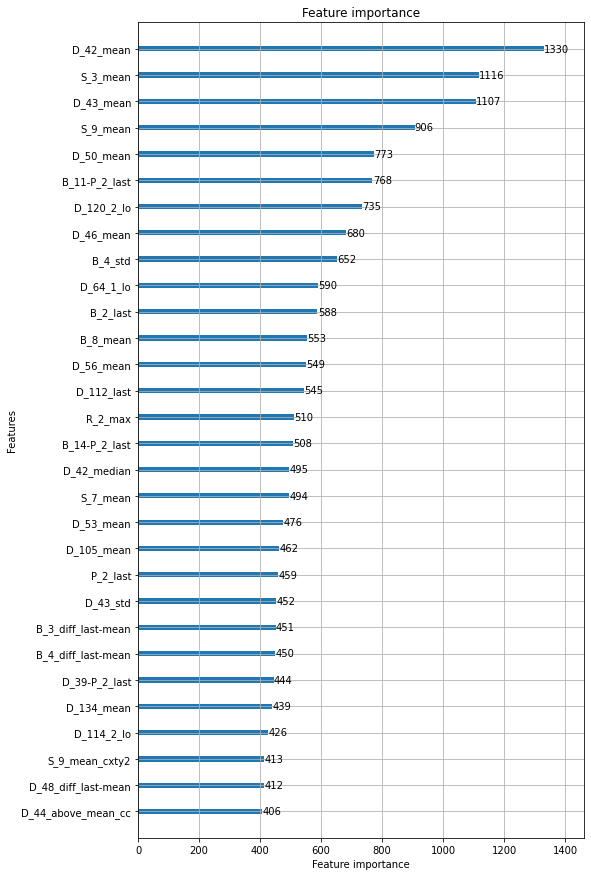

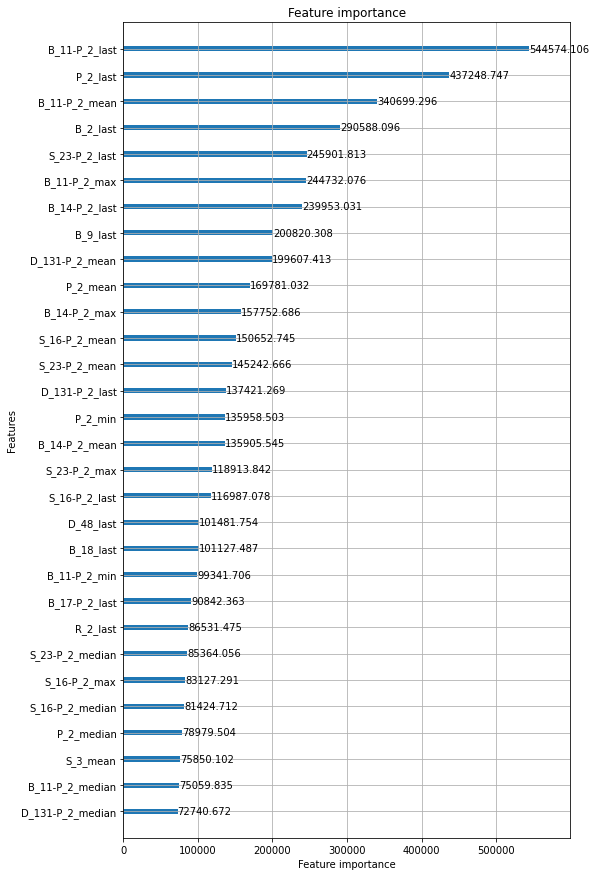

Training time: 211.01577295462292 min.


OOF recall_at4: 0.6696064900528494


OOF normalized_gini: 0.9257662517420864


OOF competition metric: 0.797686370897468


############################### repeated cross-validation step: 2/3 ################################


######################################## training model 1/5 ########################################


[50]	valid_0's amex_metric: 0.747898	valid_0's recall_at4: 0.595977	valid_0's norm_gini: 0.899819


[100]	valid_0's amex_metric: 0.758492	valid_0's recall_at4: 0.611756	valid_0's norm_gini: 0.905227


[150]	valid_0's amex_metric: 0.763949	valid_0's recall_at4: 0.620382	valid_0's norm_gini: 0.907516


[200]	valid_0's amex_metric: 0.767318	valid_0's recall_at4: 0.625431	valid_0's norm_gini: 0.909204


[250]	valid_0's amex_metric: 0.771493	valid_0's recall_at4: 0.631364	valid_0's norm_gini: 0.911622


[300]	valid_0's amex_metric: 0.773646	valid_0's recall_at4: 0.634436	valid_0's norm_gini: 0.912857


[350]	valid_0's amex_metric: 0.775543	valid_0's recall_at4: 0.637255	valid_0's norm_gini: 0.913832


[400]	valid_0's amex_metric: 0.777087	valid_0's recall_at4: 0.639485	valid_0's norm_gini: 0.914689


[450]	valid_0's amex_metric: 0.77905	valid_0's recall_at4: 0.642262	valid_0's norm_gini: 0.915838


[500]	valid_0's amex_metric: 0.781564	valid_0's recall_at4: 0.646049	valid_0's norm_gini: 0.917079


[550]	valid_0's amex_metric: 0.784267	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.918193


[600]	valid_0's amex_metric: 0.78616	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.919117


[650]	valid_0's amex_metric: 0.787686	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.91952


[700]	valid_0's amex_metric: 0.788519	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.920092


[750]	valid_0's amex_metric: 0.789092	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.920522


[800]	valid_0's amex_metric: 0.789983	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.920874


[850]	valid_0's amex_metric: 0.790514	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.921177


[900]	valid_0's amex_metric: 0.790984	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.921487


[950]	valid_0's amex_metric: 0.791463	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.921855


[1000]	valid_0's amex_metric: 0.792475	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.922197


[1050]	valid_0's amex_metric: 0.792457	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.922581


[1100]	valid_0's amex_metric: 0.793166	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.922863


[1150]	valid_0's amex_metric: 0.793251	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923034


[1200]	valid_0's amex_metric: 0.793832	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.923186


[1250]	valid_0's amex_metric: 0.794152	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.923362


[1300]	valid_0's amex_metric: 0.794353	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.923429


[1350]	valid_0's amex_metric: 0.79446	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.923557


[1400]	valid_0's amex_metric: 0.7948	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.923733


[1450]	valid_0's amex_metric: 0.795193	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.923887


[1500]	valid_0's amex_metric: 0.795269	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.92404


[1550]	valid_0's amex_metric: 0.795415	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.924206


[1600]	valid_0's amex_metric: 0.796008	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.92434


[1650]	valid_0's amex_metric: 0.795649	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.924463


[1700]	valid_0's amex_metric: 0.79608	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924567


[1750]	valid_0's amex_metric: 0.796334	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.924697


[1800]	valid_0's amex_metric: 0.79761	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.924809


[1850]	valid_0's amex_metric: 0.797833	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.924918


[1900]	valid_0's amex_metric: 0.797922	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.924969


[1950]	valid_0's amex_metric: 0.798182	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925026


[2000]	valid_0's amex_metric: 0.798771	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925153


[2050]	valid_0's amex_metric: 0.798903	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925291


[2100]	valid_0's amex_metric: 0.798964	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92537


[2150]	valid_0's amex_metric: 0.799539	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.925469


[2200]	valid_0's amex_metric: 0.799602	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.925552


[2250]	valid_0's amex_metric: 0.799659	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.925625


[2300]	valid_0's amex_metric: 0.799663	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.925633


[2350]	valid_0's amex_metric: 0.799519	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.925681


[2400]	valid_0's amex_metric: 0.799459	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925729


[2450]	valid_0's amex_metric: 0.799818	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.925774


[2500]	valid_0's amex_metric: 0.799643	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.925803


[2550]	valid_0's amex_metric: 0.799641	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.925841


[2600]	valid_0's amex_metric: 0.799649	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925898


[2650]	valid_0's amex_metric: 0.799664	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.92593


[2700]	valid_0's amex_metric: 0.800014	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.925999


[2750]	valid_0's amex_metric: 0.800267	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.926041


[2800]	valid_0's amex_metric: 0.800557	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.926074


[2850]	valid_0's amex_metric: 0.800333	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926131


[2900]	valid_0's amex_metric: 0.800568	valid_0's recall_at4: 0.674956	valid_0's norm_gini: 0.92618


[2950]	valid_0's amex_metric: 0.800833	valid_0's recall_at4: 0.675461	valid_0's norm_gini: 0.926205


[3000]	valid_0's amex_metric: 0.800742	valid_0's recall_at4: 0.67525	valid_0's norm_gini: 0.926234


[3050]	valid_0's amex_metric: 0.800489	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.926274


[3100]	valid_0's amex_metric: 0.80093	valid_0's recall_at4: 0.675587	valid_0's norm_gini: 0.926274


[3150]	valid_0's amex_metric: 0.801113	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926302


[3200]	valid_0's amex_metric: 0.801595	valid_0's recall_at4: 0.676849	valid_0's norm_gini: 0.926341


[3250]	valid_0's amex_metric: 0.801527	valid_0's recall_at4: 0.676681	valid_0's norm_gini: 0.926372


[3300]	valid_0's amex_metric: 0.801527	valid_0's recall_at4: 0.676639	valid_0's norm_gini: 0.926416


[3350]	valid_0's amex_metric: 0.801604	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926444


[3400]	valid_0's amex_metric: 0.802002	valid_0's recall_at4: 0.677565	valid_0's norm_gini: 0.92644


[3450]	valid_0's amex_metric: 0.801853	valid_0's recall_at4: 0.677228	valid_0's norm_gini: 0.926478


[3500]	valid_0's amex_metric: 0.801231	valid_0's recall_at4: 0.675966	valid_0's norm_gini: 0.926496


[3550]	valid_0's amex_metric: 0.801774	valid_0's recall_at4: 0.677018	valid_0's norm_gini: 0.92653


[3600]	valid_0's amex_metric: 0.801509	valid_0's recall_at4: 0.676471	valid_0's norm_gini: 0.926547


[3650]	valid_0's amex_metric: 0.802074	valid_0's recall_at4: 0.677565	valid_0's norm_gini: 0.926582


[3700]	valid_0's amex_metric: 0.801681	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926596


[3750]	valid_0's amex_metric: 0.801461	valid_0's recall_at4: 0.676302	valid_0's norm_gini: 0.92662


[3800]	valid_0's amex_metric: 0.800986	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.926637


[3850]	valid_0's amex_metric: 0.801226	valid_0's recall_at4: 0.675797	valid_0's norm_gini: 0.926654


[3900]	valid_0's amex_metric: 0.801371	valid_0's recall_at4: 0.67605	valid_0's norm_gini: 0.926692


[3950]	valid_0's amex_metric: 0.801828	valid_0's recall_at4: 0.676933	valid_0's norm_gini: 0.926722


[4000]	valid_0's amex_metric: 0.801771	valid_0's recall_at4: 0.676807	valid_0's norm_gini: 0.926734


[4050]	valid_0's amex_metric: 0.801893	valid_0's recall_at4: 0.677018	valid_0's norm_gini: 0.926768


[4100]	valid_0's amex_metric: 0.80186	valid_0's recall_at4: 0.676933	valid_0's norm_gini: 0.926787


[4150]	valid_0's amex_metric: 0.80212	valid_0's recall_at4: 0.677438	valid_0's norm_gini: 0.926801


[4200]	valid_0's amex_metric: 0.801884	valid_0's recall_at4: 0.676933	valid_0's norm_gini: 0.926835


[4250]	valid_0's amex_metric: 0.801951	valid_0's recall_at4: 0.67706	valid_0's norm_gini: 0.926842


[4300]	valid_0's amex_metric: 0.801854	valid_0's recall_at4: 0.676849	valid_0's norm_gini: 0.926858


[4350]	valid_0's amex_metric: 0.801816	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926868


[4400]	valid_0's amex_metric: 0.801972	valid_0's recall_at4: 0.67706	valid_0's norm_gini: 0.926884


[4450]	valid_0's amex_metric: 0.801784	valid_0's recall_at4: 0.676681	valid_0's norm_gini: 0.926886


[4500]	valid_0's amex_metric: 0.801826	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926887


[4550]	valid_0's amex_metric: 0.801578	valid_0's recall_at4: 0.67626	valid_0's norm_gini: 0.926896


[4600]	valid_0's amex_metric: 0.80177	valid_0's recall_at4: 0.676639	valid_0's norm_gini: 0.926902


[4650]	valid_0's amex_metric: 0.80217	valid_0's recall_at4: 0.677438	valid_0's norm_gini: 0.926902


[4700]	valid_0's amex_metric: 0.802265	valid_0's recall_at4: 0.677607	valid_0's norm_gini: 0.926923


[4750]	valid_0's amex_metric: 0.802297	valid_0's recall_at4: 0.677649	valid_0's norm_gini: 0.926946


[4800]	valid_0's amex_metric: 0.802521	valid_0's recall_at4: 0.67807	valid_0's norm_gini: 0.926973


[4850]	valid_0's amex_metric: 0.802418	valid_0's recall_at4: 0.677859	valid_0's norm_gini: 0.926978


[4900]	valid_0's amex_metric: 0.802023	valid_0's recall_at4: 0.67706	valid_0's norm_gini: 0.926987


[4950]	valid_0's amex_metric: 0.802596	valid_0's recall_at4: 0.678196	valid_0's norm_gini: 0.926995


[5000]	valid_0's amex_metric: 0.802174	valid_0's recall_at4: 0.677354	valid_0's norm_gini: 0.926994


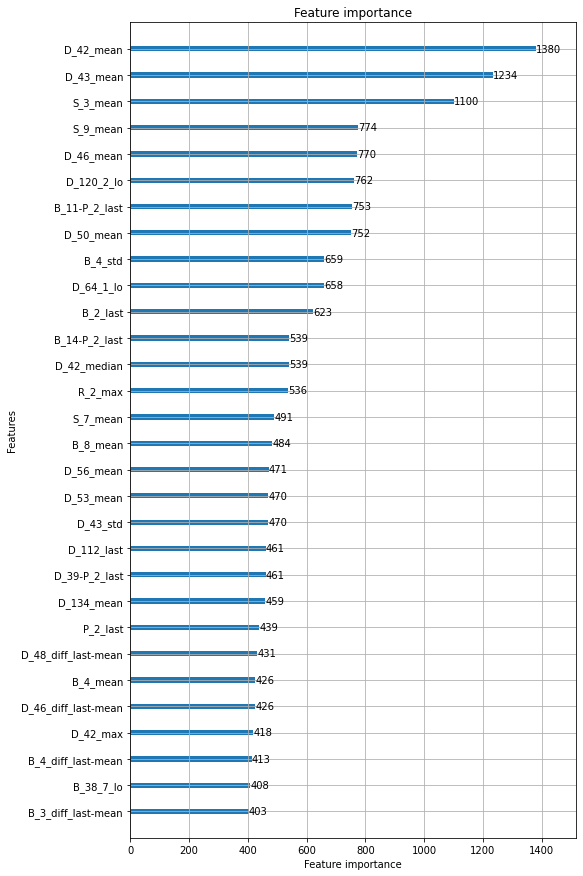

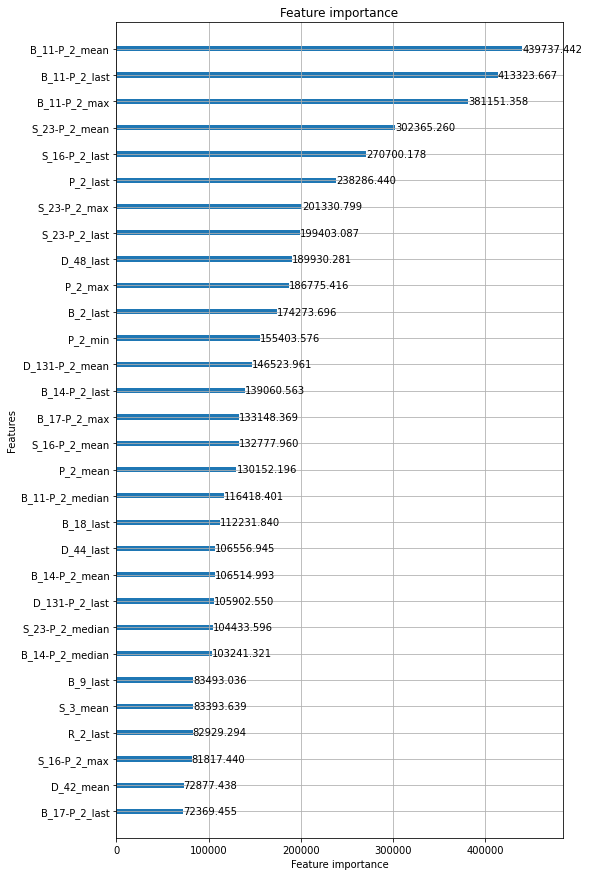

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.744452	valid_0's recall_at4: 0.590844	valid_0's norm_gini: 0.89806


[100]	valid_0's amex_metric: 0.755085	valid_0's recall_at4: 0.606413	valid_0's norm_gini: 0.903756


[150]	valid_0's amex_metric: 0.760384	valid_0's recall_at4: 0.614449	valid_0's norm_gini: 0.906318


[200]	valid_0's amex_metric: 0.76343	valid_0's recall_at4: 0.618825	valid_0's norm_gini: 0.908035


[250]	valid_0's amex_metric: 0.767133	valid_0's recall_at4: 0.624127	valid_0's norm_gini: 0.91014


[300]	valid_0's amex_metric: 0.769344	valid_0's recall_at4: 0.626904	valid_0's norm_gini: 0.911783


[350]	valid_0's amex_metric: 0.770701	valid_0's recall_at4: 0.628755	valid_0's norm_gini: 0.912647


[400]	valid_0's amex_metric: 0.771512	valid_0's recall_at4: 0.629807	valid_0's norm_gini: 0.913216


[450]	valid_0's amex_metric: 0.774456	valid_0's recall_at4: 0.634562	valid_0's norm_gini: 0.91435


[500]	valid_0's amex_metric: 0.777079	valid_0's recall_at4: 0.638559	valid_0's norm_gini: 0.915599


[550]	valid_0's amex_metric: 0.778466	valid_0's recall_at4: 0.640242	valid_0's norm_gini: 0.916689


[600]	valid_0's amex_metric: 0.780921	valid_0's recall_at4: 0.644198	valid_0's norm_gini: 0.917644


[650]	valid_0's amex_metric: 0.781173	valid_0's recall_at4: 0.644324	valid_0's norm_gini: 0.918022


[700]	valid_0's amex_metric: 0.781993	valid_0's recall_at4: 0.645418	valid_0's norm_gini: 0.918568


[750]	valid_0's amex_metric: 0.783471	valid_0's recall_at4: 0.647985	valid_0's norm_gini: 0.918958


[800]	valid_0's amex_metric: 0.784449	valid_0's recall_at4: 0.649583	valid_0's norm_gini: 0.919315


[850]	valid_0's amex_metric: 0.785054	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.919641


[900]	valid_0's amex_metric: 0.785022	valid_0's recall_at4: 0.65013	valid_0's norm_gini: 0.919914


[950]	valid_0's amex_metric: 0.78574	valid_0's recall_at4: 0.651224	valid_0's norm_gini: 0.920256


[1000]	valid_0's amex_metric: 0.786437	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.920599


[1050]	valid_0's amex_metric: 0.786835	valid_0's recall_at4: 0.652697	valid_0's norm_gini: 0.920974


[1100]	valid_0's amex_metric: 0.787451	valid_0's recall_at4: 0.653665	valid_0's norm_gini: 0.921238


[1150]	valid_0's amex_metric: 0.787933	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.921444


[1200]	valid_0's amex_metric: 0.788547	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.92162


[1250]	valid_0's amex_metric: 0.789203	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.921838


[1300]	valid_0's amex_metric: 0.789268	valid_0's recall_at4: 0.656652	valid_0's norm_gini: 0.921883


[1350]	valid_0's amex_metric: 0.789593	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.921987


[1400]	valid_0's amex_metric: 0.790284	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.922149


[1450]	valid_0's amex_metric: 0.790425	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.922262


[1500]	valid_0's amex_metric: 0.790838	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.922372


[1550]	valid_0's amex_metric: 0.791755	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.922566


[1600]	valid_0's amex_metric: 0.79216	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922702


[1650]	valid_0's amex_metric: 0.792143	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.922795


[1700]	valid_0's amex_metric: 0.79225	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922883


[1750]	valid_0's amex_metric: 0.792339	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.922976


[1800]	valid_0's amex_metric: 0.792499	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923085


[1850]	valid_0's amex_metric: 0.792401	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923185


[1900]	valid_0's amex_metric: 0.792708	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.923209


[1950]	valid_0's amex_metric: 0.792598	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923284


[2000]	valid_0's amex_metric: 0.792818	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923387


[2050]	valid_0's amex_metric: 0.793359	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923501


[2100]	valid_0's amex_metric: 0.79345	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923599


[2150]	valid_0's amex_metric: 0.793613	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.923672


[2200]	valid_0's amex_metric: 0.793931	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.923761


[2250]	valid_0's amex_metric: 0.794186	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.923808


[2300]	valid_0's amex_metric: 0.793803	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.923843


[2350]	valid_0's amex_metric: 0.793893	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.923896


[2400]	valid_0's amex_metric: 0.793968	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.923962


[2450]	valid_0's amex_metric: 0.794121	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924015


[2500]	valid_0's amex_metric: 0.793683	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924066


[2550]	valid_0's amex_metric: 0.794436	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924099


[2600]	valid_0's amex_metric: 0.794564	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924144


[2650]	valid_0's amex_metric: 0.794026	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924162


[2700]	valid_0's amex_metric: 0.794592	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924201


[2750]	valid_0's amex_metric: 0.794834	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924263


[2800]	valid_0's amex_metric: 0.7949	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.924311


[2850]	valid_0's amex_metric: 0.794874	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924386


[2900]	valid_0's amex_metric: 0.795301	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.924441


[2950]	valid_0's amex_metric: 0.795119	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924456


[3000]	valid_0's amex_metric: 0.795099	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924457


[3050]	valid_0's amex_metric: 0.794939	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924474


[3100]	valid_0's amex_metric: 0.795157	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924489


[3150]	valid_0's amex_metric: 0.794761	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924539


[3200]	valid_0's amex_metric: 0.795449	valid_0's recall_at4: 0.66633	valid_0's norm_gini: 0.924567


[3250]	valid_0's amex_metric: 0.795273	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.924594


[3300]	valid_0's amex_metric: 0.795544	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924632


[3350]	valid_0's amex_metric: 0.795286	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924663


[3400]	valid_0's amex_metric: 0.795249	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924673


[3450]	valid_0's amex_metric: 0.795025	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924688


[3500]	valid_0's amex_metric: 0.795415	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.92471


[3550]	valid_0's amex_metric: 0.79566	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.924737


[3600]	valid_0's amex_metric: 0.795614	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924771


[3650]	valid_0's amex_metric: 0.795647	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.924796


[3700]	valid_0's amex_metric: 0.795466	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924813


[3750]	valid_0's amex_metric: 0.795264	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924829


[3800]	valid_0's amex_metric: 0.795216	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.92486


[3850]	valid_0's amex_metric: 0.795377	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924886


[3900]	valid_0's amex_metric: 0.795215	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.9249


[3950]	valid_0's amex_metric: 0.795163	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924921


[4000]	valid_0's amex_metric: 0.794854	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924934


[4050]	valid_0's amex_metric: 0.795182	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924961


[4100]	valid_0's amex_metric: 0.795305	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924995


[4150]	valid_0's amex_metric: 0.79521	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.925016


[4200]	valid_0's amex_metric: 0.795386	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.925032


[4250]	valid_0's amex_metric: 0.795455	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.925044


[4300]	valid_0's amex_metric: 0.795228	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.925051


[4350]	valid_0's amex_metric: 0.795359	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.925062


[4400]	valid_0's amex_metric: 0.795267	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.925088


[4450]	valid_0's amex_metric: 0.795591	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.925104


[4500]	valid_0's amex_metric: 0.796116	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925144


[4550]	valid_0's amex_metric: 0.795677	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.925151


[4600]	valid_0's amex_metric: 0.795804	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.925153


[4650]	valid_0's amex_metric: 0.795911	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925156


[4700]	valid_0's amex_metric: 0.796003	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.925171


[4750]	valid_0's amex_metric: 0.796271	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.925202


[4800]	valid_0's amex_metric: 0.796297	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.925212


[4850]	valid_0's amex_metric: 0.796685	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.92523


[4900]	valid_0's amex_metric: 0.79616	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925233


[4950]	valid_0's amex_metric: 0.796231	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925249


[5000]	valid_0's amex_metric: 0.795879	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.925259


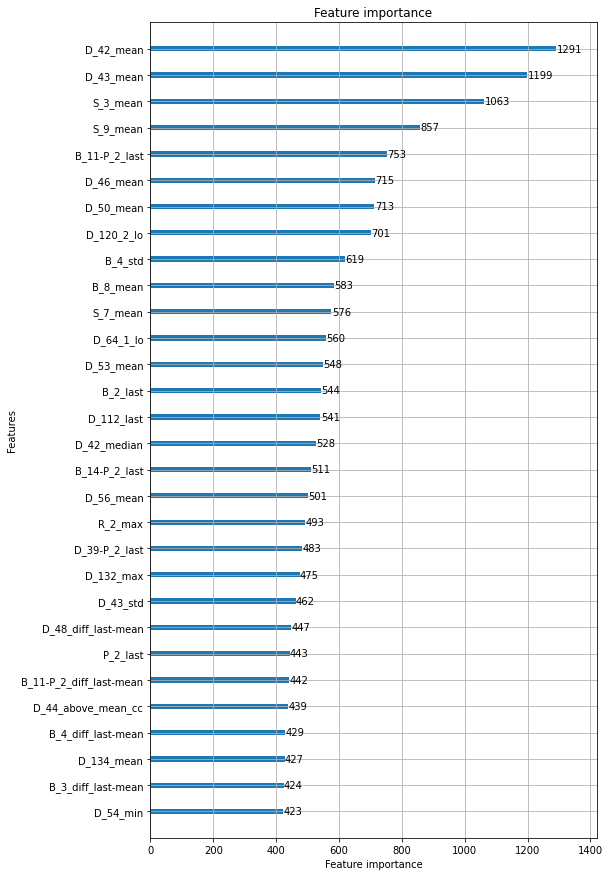

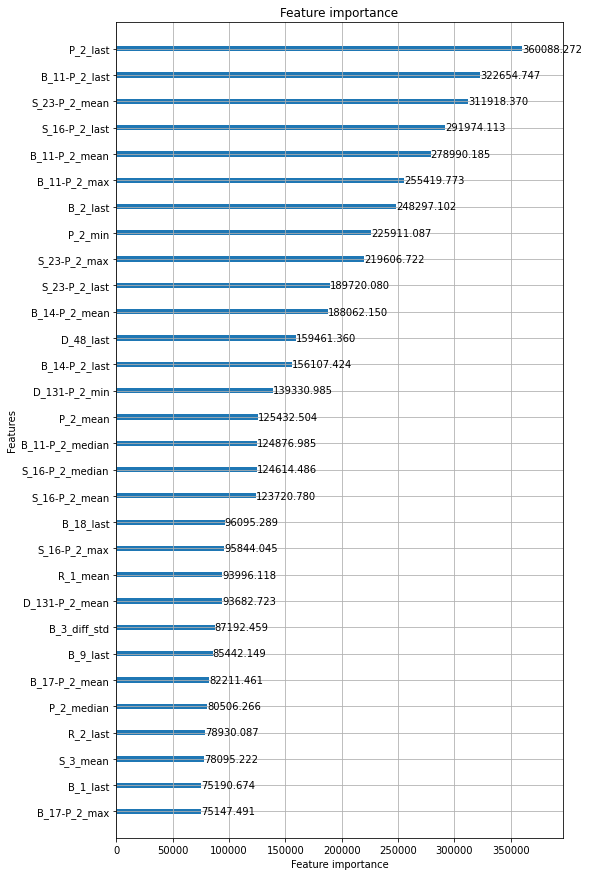

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.740794	valid_0's recall_at4: 0.584154	valid_0's norm_gini: 0.897434


[100]	valid_0's amex_metric: 0.750214	valid_0's recall_at4: 0.598208	valid_0's norm_gini: 0.90222


[150]	valid_0's amex_metric: 0.75465	valid_0's recall_at4: 0.604393	valid_0's norm_gini: 0.904908


[200]	valid_0's amex_metric: 0.756777	valid_0's recall_at4: 0.607296	valid_0's norm_gini: 0.906259


[250]	valid_0's amex_metric: 0.761546	valid_0's recall_at4: 0.614239	valid_0's norm_gini: 0.908853


[300]	valid_0's amex_metric: 0.764226	valid_0's recall_at4: 0.618152	valid_0's norm_gini: 0.9103


[350]	valid_0's amex_metric: 0.766844	valid_0's recall_at4: 0.622444	valid_0's norm_gini: 0.911245


[400]	valid_0's amex_metric: 0.768251	valid_0's recall_at4: 0.624379	valid_0's norm_gini: 0.912123


[450]	valid_0's amex_metric: 0.770427	valid_0's recall_at4: 0.627619	valid_0's norm_gini: 0.913234


[500]	valid_0's amex_metric: 0.771907	valid_0's recall_at4: 0.629176	valid_0's norm_gini: 0.914638


[550]	valid_0's amex_metric: 0.774472	valid_0's recall_at4: 0.633005	valid_0's norm_gini: 0.915939


[600]	valid_0's amex_metric: 0.776852	valid_0's recall_at4: 0.636876	valid_0's norm_gini: 0.916828


[650]	valid_0's amex_metric: 0.778489	valid_0's recall_at4: 0.639611	valid_0's norm_gini: 0.917367


[700]	valid_0's amex_metric: 0.779159	valid_0's recall_at4: 0.640411	valid_0's norm_gini: 0.917908


[750]	valid_0's amex_metric: 0.779628	valid_0's recall_at4: 0.641084	valid_0's norm_gini: 0.918172


[800]	valid_0's amex_metric: 0.780504	valid_0's recall_at4: 0.642472	valid_0's norm_gini: 0.918535


[850]	valid_0's amex_metric: 0.78069	valid_0's recall_at4: 0.642515	valid_0's norm_gini: 0.918865


[900]	valid_0's amex_metric: 0.781444	valid_0's recall_at4: 0.643693	valid_0's norm_gini: 0.919196


[950]	valid_0's amex_metric: 0.78242	valid_0's recall_at4: 0.64525	valid_0's norm_gini: 0.919591


[1000]	valid_0's amex_metric: 0.782713	valid_0's recall_at4: 0.645544	valid_0's norm_gini: 0.919882


[1050]	valid_0's amex_metric: 0.784248	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.920343


[1100]	valid_0's amex_metric: 0.784678	valid_0's recall_at4: 0.648742	valid_0's norm_gini: 0.920614


[1150]	valid_0's amex_metric: 0.784725	valid_0's recall_at4: 0.648616	valid_0's norm_gini: 0.920834


[1200]	valid_0's amex_metric: 0.785531	valid_0's recall_at4: 0.650046	valid_0's norm_gini: 0.921016


[1250]	valid_0's amex_metric: 0.785434	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.921243


[1300]	valid_0's amex_metric: 0.785532	valid_0's recall_at4: 0.649752	valid_0's norm_gini: 0.921312


[1350]	valid_0's amex_metric: 0.786495	valid_0's recall_at4: 0.651519	valid_0's norm_gini: 0.92147


[1400]	valid_0's amex_metric: 0.78664	valid_0's recall_at4: 0.651603	valid_0's norm_gini: 0.921678


[1450]	valid_0's amex_metric: 0.78752	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921838


[1500]	valid_0's amex_metric: 0.787361	valid_0's recall_at4: 0.652739	valid_0's norm_gini: 0.921982


[1550]	valid_0's amex_metric: 0.788212	valid_0's recall_at4: 0.654296	valid_0's norm_gini: 0.922129


[1600]	valid_0's amex_metric: 0.788034	valid_0's recall_at4: 0.653749	valid_0's norm_gini: 0.922318


[1650]	valid_0's amex_metric: 0.788483	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.92246


[1700]	valid_0's amex_metric: 0.788143	valid_0's recall_at4: 0.653749	valid_0's norm_gini: 0.922538


[1750]	valid_0's amex_metric: 0.78842	valid_0's recall_at4: 0.65417	valid_0's norm_gini: 0.922671


[1800]	valid_0's amex_metric: 0.78899	valid_0's recall_at4: 0.655222	valid_0's norm_gini: 0.922758


[1850]	valid_0's amex_metric: 0.789111	valid_0's recall_at4: 0.655348	valid_0's norm_gini: 0.922875


[1900]	valid_0's amex_metric: 0.789837	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.922938


[1950]	valid_0's amex_metric: 0.790214	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.923019


[2000]	valid_0's amex_metric: 0.790537	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.92316


[2050]	valid_0's amex_metric: 0.790929	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.923269


[2100]	valid_0's amex_metric: 0.790712	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.923384


[2150]	valid_0's amex_metric: 0.790921	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.923464


[2200]	valid_0's amex_metric: 0.790941	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.923547


[2250]	valid_0's amex_metric: 0.79162	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.923642


[2300]	valid_0's amex_metric: 0.791795	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923655


[2350]	valid_0's amex_metric: 0.791534	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.92368


[2400]	valid_0's amex_metric: 0.791396	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.923742


[2450]	valid_0's amex_metric: 0.791437	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923782


[2500]	valid_0's amex_metric: 0.791258	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.923843


[2550]	valid_0's amex_metric: 0.791074	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923897


[2600]	valid_0's amex_metric: 0.791185	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.92395


[2650]	valid_0's amex_metric: 0.791617	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.924015


[2700]	valid_0's amex_metric: 0.791568	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.924043


[2750]	valid_0's amex_metric: 0.791969	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924087


[2800]	valid_0's amex_metric: 0.792377	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.924103


[2850]	valid_0's amex_metric: 0.792044	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.924154


[2900]	valid_0's amex_metric: 0.791981	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.924196


[2950]	valid_0's amex_metric: 0.792035	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.92422


[3000]	valid_0's amex_metric: 0.792668	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.924224


[3050]	valid_0's amex_metric: 0.792809	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.924252


[3100]	valid_0's amex_metric: 0.792519	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924304


[3150]	valid_0's amex_metric: 0.792157	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.924338


[3200]	valid_0's amex_metric: 0.792469	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.924372


[3250]	valid_0's amex_metric: 0.792677	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.924409


[3300]	valid_0's amex_metric: 0.792924	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.92444


[3350]	valid_0's amex_metric: 0.793014	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924453


[3400]	valid_0's amex_metric: 0.792839	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.924481


[3450]	valid_0's amex_metric: 0.79313	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.924516


[3500]	valid_0's amex_metric: 0.793435	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.924537


[3550]	valid_0's amex_metric: 0.793192	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924556


[3600]	valid_0's amex_metric: 0.79299	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924572


[3650]	valid_0's amex_metric: 0.792986	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.924608


[3700]	valid_0's amex_metric: 0.792692	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924609


[3750]	valid_0's amex_metric: 0.792785	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.924626


[3800]	valid_0's amex_metric: 0.79288	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.924648


[3850]	valid_0's amex_metric: 0.792996	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.92467


[3900]	valid_0's amex_metric: 0.793191	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924681


[3950]	valid_0's amex_metric: 0.793015	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.924706


[4000]	valid_0's amex_metric: 0.793157	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.92474


[4050]	valid_0's amex_metric: 0.793193	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924769


[4100]	valid_0's amex_metric: 0.793755	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924799


[4150]	valid_0's amex_metric: 0.793754	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924797


[4200]	valid_0's amex_metric: 0.793613	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.92481


[4250]	valid_0's amex_metric: 0.793775	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924839


[4300]	valid_0's amex_metric: 0.79378	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924848


[4350]	valid_0's amex_metric: 0.794083	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924866


[4400]	valid_0's amex_metric: 0.793966	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924885


[4450]	valid_0's amex_metric: 0.794223	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924893


[4500]	valid_0's amex_metric: 0.79411	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.92492


[4550]	valid_0's amex_metric: 0.793936	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924908


[4600]	valid_0's amex_metric: 0.79371	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.924919


[4650]	valid_0's amex_metric: 0.794176	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.924924


[4700]	valid_0's amex_metric: 0.793943	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924921


[4750]	valid_0's amex_metric: 0.793801	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924933


[4800]	valid_0's amex_metric: 0.794266	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924936


[4850]	valid_0's amex_metric: 0.79455	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924958


[4900]	valid_0's amex_metric: 0.794248	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.924986


[4950]	valid_0's amex_metric: 0.794378	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924992


[5000]	valid_0's amex_metric: 0.794256	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925001


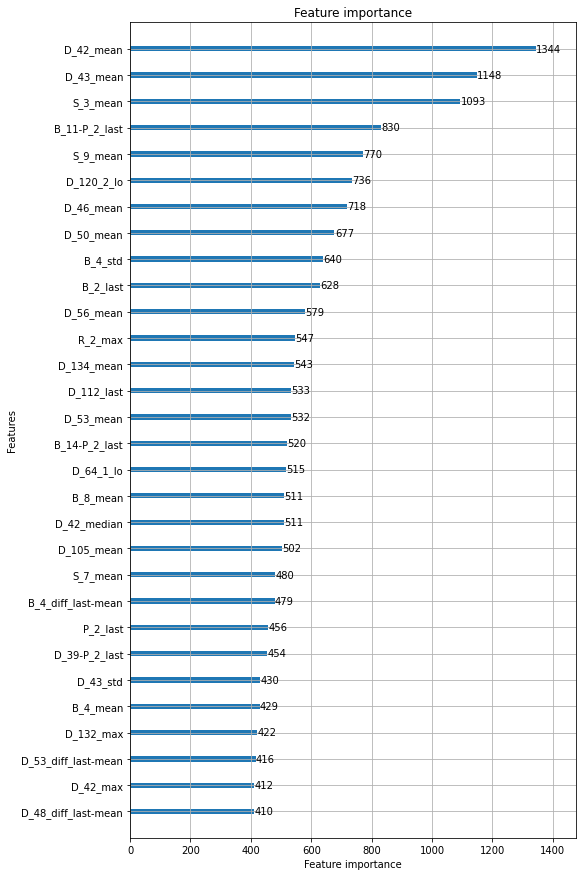

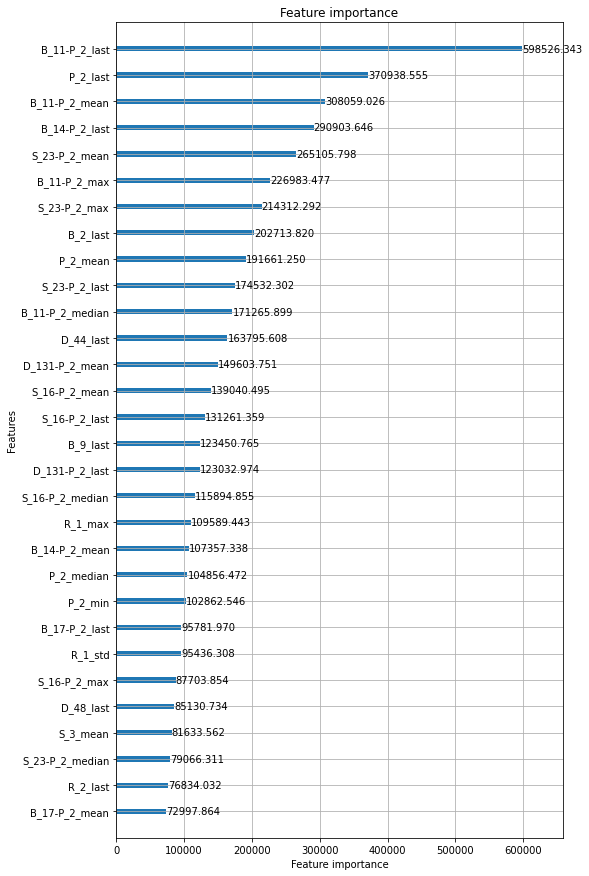

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.744935	valid_0's recall_at4: 0.591079	valid_0's norm_gini: 0.898792


[100]	valid_0's amex_metric: 0.755259	valid_0's recall_at4: 0.606354	valid_0's norm_gini: 0.904164


[150]	valid_0's amex_metric: 0.761334	valid_0's recall_at4: 0.615653	valid_0's norm_gini: 0.907015


[200]	valid_0's amex_metric: 0.764575	valid_0's recall_at4: 0.620114	valid_0's norm_gini: 0.909037


[250]	valid_0's amex_metric: 0.767395	valid_0's recall_at4: 0.623859	valid_0's norm_gini: 0.910932


[300]	valid_0's amex_metric: 0.770614	valid_0's recall_at4: 0.628866	valid_0's norm_gini: 0.912362


[350]	valid_0's amex_metric: 0.772836	valid_0's recall_at4: 0.632358	valid_0's norm_gini: 0.913313


[400]	valid_0's amex_metric: 0.774378	valid_0's recall_at4: 0.634715	valid_0's norm_gini: 0.914041


[450]	valid_0's amex_metric: 0.776425	valid_0's recall_at4: 0.637618	valid_0's norm_gini: 0.915231


[500]	valid_0's amex_metric: 0.779064	valid_0's recall_at4: 0.641616	valid_0's norm_gini: 0.916512


[550]	valid_0's amex_metric: 0.782072	valid_0's recall_at4: 0.646497	valid_0's norm_gini: 0.917648


[600]	valid_0's amex_metric: 0.783375	valid_0's recall_at4: 0.64818	valid_0's norm_gini: 0.918571


[650]	valid_0's amex_metric: 0.784938	valid_0's recall_at4: 0.650915	valid_0's norm_gini: 0.918961


[700]	valid_0's amex_metric: 0.786394	valid_0's recall_at4: 0.653356	valid_0's norm_gini: 0.919432


[750]	valid_0's amex_metric: 0.787741	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.919769


[800]	valid_0's amex_metric: 0.788359	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.920123


[850]	valid_0's amex_metric: 0.788847	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.920425


[900]	valid_0's amex_metric: 0.789624	valid_0's recall_at4: 0.658531	valid_0's norm_gini: 0.920716


[950]	valid_0's amex_metric: 0.790392	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.921031


[1000]	valid_0's amex_metric: 0.791208	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.921318


[1050]	valid_0's amex_metric: 0.791263	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.921681


[1100]	valid_0's amex_metric: 0.792051	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.92191


[1150]	valid_0's amex_metric: 0.792176	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.922117


[1200]	valid_0's amex_metric: 0.79237	valid_0's recall_at4: 0.662445	valid_0's norm_gini: 0.922295


[1250]	valid_0's amex_metric: 0.792582	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.922551


[1300]	valid_0's amex_metric: 0.792761	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.922572


[1350]	valid_0's amex_metric: 0.793011	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.922693


[1400]	valid_0's amex_metric: 0.793479	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.922872


[1450]	valid_0's amex_metric: 0.793458	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.923041


[1500]	valid_0's amex_metric: 0.794081	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.92315


[1550]	valid_0's amex_metric: 0.794788	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.923345


[1600]	valid_0's amex_metric: 0.794987	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.92349


[1650]	valid_0's amex_metric: 0.795387	valid_0's recall_at4: 0.6672	valid_0's norm_gini: 0.923573


[1700]	valid_0's amex_metric: 0.7958	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.923685


[1750]	valid_0's amex_metric: 0.795957	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.92379


[1800]	valid_0's amex_metric: 0.796008	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.92389


[1850]	valid_0's amex_metric: 0.795956	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.923996


[1900]	valid_0's amex_metric: 0.795798	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.92406


[1950]	valid_0's amex_metric: 0.795823	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.924152


[2000]	valid_0's amex_metric: 0.796664	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.924276


[2050]	valid_0's amex_metric: 0.796689	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.924369


[2100]	valid_0's amex_metric: 0.797172	valid_0's recall_at4: 0.669893	valid_0's norm_gini: 0.924452


[2150]	valid_0's amex_metric: 0.796981	valid_0's recall_at4: 0.66943	valid_0's norm_gini: 0.924532


[2200]	valid_0's amex_metric: 0.796743	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.924645


[2250]	valid_0's amex_metric: 0.797088	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.924705


[2300]	valid_0's amex_metric: 0.797468	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.92475


[2350]	valid_0's amex_metric: 0.797511	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.924793


[2400]	valid_0's amex_metric: 0.797428	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.924838


[2450]	valid_0's amex_metric: 0.797684	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.924886


[2500]	valid_0's amex_metric: 0.79802	valid_0's recall_at4: 0.671113	valid_0's norm_gini: 0.924927


[2550]	valid_0's amex_metric: 0.797849	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.924964


[2600]	valid_0's amex_metric: 0.798154	valid_0's recall_at4: 0.671281	valid_0's norm_gini: 0.925028


[2650]	valid_0's amex_metric: 0.798388	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.925074


[2700]	valid_0's amex_metric: 0.798316	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.925099


[2750]	valid_0's amex_metric: 0.798731	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.925128


[2800]	valid_0's amex_metric: 0.798982	valid_0's recall_at4: 0.672796	valid_0's norm_gini: 0.925168


[2850]	valid_0's amex_metric: 0.798963	valid_0's recall_at4: 0.672712	valid_0's norm_gini: 0.925213


[2900]	valid_0's amex_metric: 0.799125	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.925243


[2950]	valid_0's amex_metric: 0.799419	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.925243


[3000]	valid_0's amex_metric: 0.798832	valid_0's recall_at4: 0.672375	valid_0's norm_gini: 0.925288


[3050]	valid_0's amex_metric: 0.79891	valid_0's recall_at4: 0.672502	valid_0's norm_gini: 0.925318


[3100]	valid_0's amex_metric: 0.799216	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.925342


[3150]	valid_0's amex_metric: 0.799256	valid_0's recall_at4: 0.673133	valid_0's norm_gini: 0.925378


[3200]	valid_0's amex_metric: 0.799589	valid_0's recall_at4: 0.673764	valid_0's norm_gini: 0.925413


[3250]	valid_0's amex_metric: 0.79955	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.925463


[3300]	valid_0's amex_metric: 0.799635	valid_0's recall_at4: 0.673764	valid_0's norm_gini: 0.925506


[3350]	valid_0's amex_metric: 0.799407	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.925513


[3400]	valid_0's amex_metric: 0.799372	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.925526


[3450]	valid_0's amex_metric: 0.799509	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.925549


[3500]	valid_0's amex_metric: 0.800107	valid_0's recall_at4: 0.674648	valid_0's norm_gini: 0.925566


[3550]	valid_0's amex_metric: 0.799876	valid_0's recall_at4: 0.674143	valid_0's norm_gini: 0.92561


[3600]	valid_0's amex_metric: 0.799718	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.925631


[3650]	valid_0's amex_metric: 0.79978	valid_0's recall_at4: 0.67389	valid_0's norm_gini: 0.92567


[3700]	valid_0's amex_metric: 0.799811	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.92569


[3750]	valid_0's amex_metric: 0.799474	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.92569


[3800]	valid_0's amex_metric: 0.799572	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.925716


[3850]	valid_0's amex_metric: 0.799877	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.925737


[3900]	valid_0's amex_metric: 0.799588	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.92575


[3950]	valid_0's amex_metric: 0.800124	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.925768


[4000]	valid_0's amex_metric: 0.799395	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.925784


[4050]	valid_0's amex_metric: 0.799616	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.925804


[4100]	valid_0's amex_metric: 0.799995	valid_0's recall_at4: 0.674143	valid_0's norm_gini: 0.925847


[4150]	valid_0's amex_metric: 0.799768	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.925857


[4200]	valid_0's amex_metric: 0.800221	valid_0's recall_at4: 0.674563	valid_0's norm_gini: 0.925879


[4250]	valid_0's amex_metric: 0.800169	valid_0's recall_at4: 0.674437	valid_0's norm_gini: 0.9259


[4300]	valid_0's amex_metric: 0.800108	valid_0's recall_at4: 0.674311	valid_0's norm_gini: 0.925906


[4350]	valid_0's amex_metric: 0.799775	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.925912


[4400]	valid_0's amex_metric: 0.800002	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.925945


[4450]	valid_0's amex_metric: 0.800112	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.925956


[4500]	valid_0's amex_metric: 0.800184	valid_0's recall_at4: 0.674395	valid_0's norm_gini: 0.925972


[4550]	valid_0's amex_metric: 0.800529	valid_0's recall_at4: 0.675068	valid_0's norm_gini: 0.925989


[4600]	valid_0's amex_metric: 0.800235	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.92599


[4650]	valid_0's amex_metric: 0.800558	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.926006


[4700]	valid_0's amex_metric: 0.800502	valid_0's recall_at4: 0.674984	valid_0's norm_gini: 0.926019


[4750]	valid_0's amex_metric: 0.800404	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.926034


[4800]	valid_0's amex_metric: 0.800182	valid_0's recall_at4: 0.674311	valid_0's norm_gini: 0.926053


[4850]	valid_0's amex_metric: 0.800493	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.926085


[4900]	valid_0's amex_metric: 0.800444	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.926115


[4950]	valid_0's amex_metric: 0.800367	valid_0's recall_at4: 0.674605	valid_0's norm_gini: 0.926129


[5000]	valid_0's amex_metric: 0.800243	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926133


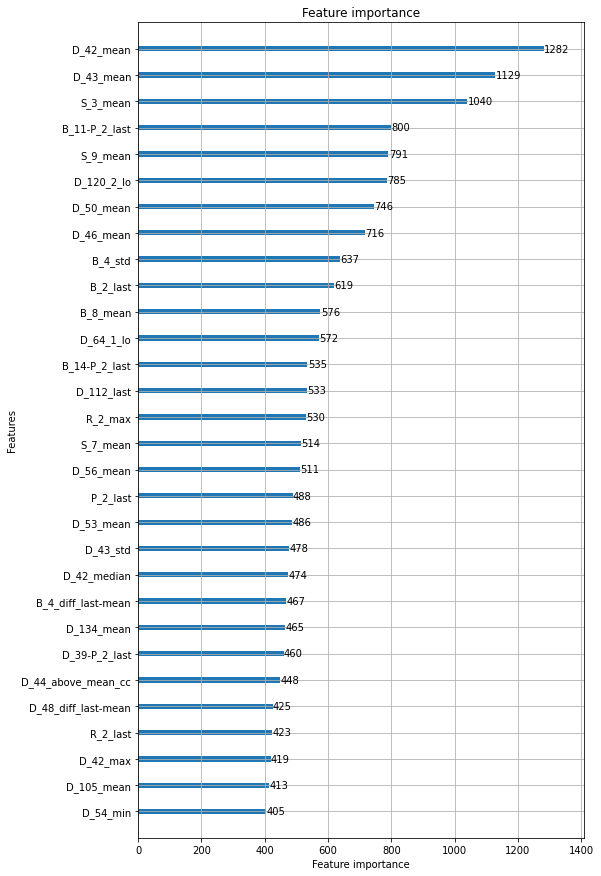

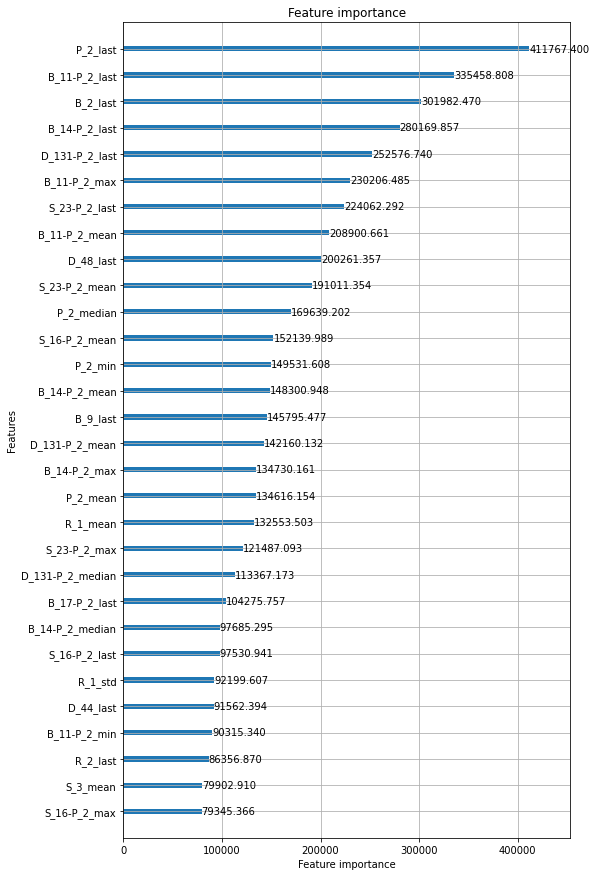

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.749748	valid_0's recall_at4: 0.599411	valid_0's norm_gini: 0.900085


[100]	valid_0's amex_metric: 0.75816	valid_0's recall_at4: 0.610856	valid_0's norm_gini: 0.905463


[150]	valid_0's amex_metric: 0.763956	valid_0's recall_at4: 0.619987	valid_0's norm_gini: 0.907925


[200]	valid_0's amex_metric: 0.767039	valid_0's recall_at4: 0.624616	valid_0's norm_gini: 0.909461


[250]	valid_0's amex_metric: 0.770031	valid_0's recall_at4: 0.628656	valid_0's norm_gini: 0.911407


[300]	valid_0's amex_metric: 0.774073	valid_0's recall_at4: 0.635136	valid_0's norm_gini: 0.91301


[350]	valid_0's amex_metric: 0.775227	valid_0's recall_at4: 0.636651	valid_0's norm_gini: 0.913804


[400]	valid_0's amex_metric: 0.776475	valid_0's recall_at4: 0.638376	valid_0's norm_gini: 0.914574


[450]	valid_0's amex_metric: 0.778659	valid_0's recall_at4: 0.641658	valid_0's norm_gini: 0.915661


[500]	valid_0's amex_metric: 0.780193	valid_0's recall_at4: 0.643509	valid_0's norm_gini: 0.916876


[550]	valid_0's amex_metric: 0.781371	valid_0's recall_at4: 0.644772	valid_0's norm_gini: 0.917969


[600]	valid_0's amex_metric: 0.783608	valid_0's recall_at4: 0.648433	valid_0's norm_gini: 0.918783


[650]	valid_0's amex_metric: 0.785083	valid_0's recall_at4: 0.650915	valid_0's norm_gini: 0.919252


[700]	valid_0's amex_metric: 0.785931	valid_0's recall_at4: 0.652093	valid_0's norm_gini: 0.919769


[750]	valid_0's amex_metric: 0.786671	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.920112


[800]	valid_0's amex_metric: 0.78664	valid_0's recall_at4: 0.652767	valid_0's norm_gini: 0.920514


[850]	valid_0's amex_metric: 0.787446	valid_0's recall_at4: 0.654029	valid_0's norm_gini: 0.920863


[900]	valid_0's amex_metric: 0.788719	valid_0's recall_at4: 0.656301	valid_0's norm_gini: 0.921136


[950]	valid_0's amex_metric: 0.789391	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.921556


[1000]	valid_0's amex_metric: 0.790546	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.921845


[1050]	valid_0's amex_metric: 0.791099	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.922237


[1100]	valid_0's amex_metric: 0.791648	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.922493


[1150]	valid_0's amex_metric: 0.791905	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.92267


[1200]	valid_0's amex_metric: 0.791866	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.922844


[1250]	valid_0's amex_metric: 0.792656	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.923035


[1300]	valid_0's amex_metric: 0.792398	valid_0's recall_at4: 0.661729	valid_0's norm_gini: 0.923067


[1350]	valid_0's amex_metric: 0.792864	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.923199


[1400]	valid_0's amex_metric: 0.793344	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.92336


[1450]	valid_0's amex_metric: 0.793431	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.923491


[1500]	valid_0's amex_metric: 0.793754	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.923633


[1550]	valid_0's amex_metric: 0.793559	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923789


[1600]	valid_0's amex_metric: 0.793779	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.923935


[1650]	valid_0's amex_metric: 0.794051	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.924017


[1700]	valid_0's amex_metric: 0.794548	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924085


[1750]	valid_0's amex_metric: 0.794794	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.924155


[1800]	valid_0's amex_metric: 0.794632	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924253


[1850]	valid_0's amex_metric: 0.794118	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.92436


[1900]	valid_0's amex_metric: 0.794817	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.924412


[1950]	valid_0's amex_metric: 0.795023	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.924446


[2000]	valid_0's amex_metric: 0.796181	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.924532


[2050]	valid_0's amex_metric: 0.795792	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.924637


[2100]	valid_0's amex_metric: 0.796134	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924731


[2150]	valid_0's amex_metric: 0.795465	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.924824


[2200]	valid_0's amex_metric: 0.795949	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.924867


[2250]	valid_0's amex_metric: 0.79553	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.924913


[2300]	valid_0's amex_metric: 0.795311	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924979


[2350]	valid_0's amex_metric: 0.795695	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.925032


[2400]	valid_0's amex_metric: 0.795797	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.925068


[2450]	valid_0's amex_metric: 0.795834	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.925141


[2500]	valid_0's amex_metric: 0.79603	valid_0's recall_at4: 0.666863	valid_0's norm_gini: 0.925197


[2550]	valid_0's amex_metric: 0.795681	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925256


[2600]	valid_0's amex_metric: 0.796077	valid_0's recall_at4: 0.666863	valid_0's norm_gini: 0.925291


[2650]	valid_0's amex_metric: 0.795826	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.925335


[2700]	valid_0's amex_metric: 0.796112	valid_0's recall_at4: 0.666821	valid_0's norm_gini: 0.925404


[2750]	valid_0's amex_metric: 0.796069	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.925444


[2800]	valid_0's amex_metric: 0.795889	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.925504


[2850]	valid_0's amex_metric: 0.79658	valid_0's recall_at4: 0.667578	valid_0's norm_gini: 0.925582


[2900]	valid_0's amex_metric: 0.797069	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.925633


[2950]	valid_0's amex_metric: 0.796913	valid_0's recall_at4: 0.668167	valid_0's norm_gini: 0.925659


[3000]	valid_0's amex_metric: 0.797157	valid_0's recall_at4: 0.66863	valid_0's norm_gini: 0.925684


[3050]	valid_0's amex_metric: 0.79739	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.925728


[3100]	valid_0's amex_metric: 0.797377	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.925746


[3150]	valid_0's amex_metric: 0.79705	valid_0's recall_at4: 0.668336	valid_0's norm_gini: 0.925765


[3200]	valid_0's amex_metric: 0.797517	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.925773


[3250]	valid_0's amex_metric: 0.796904	valid_0's recall_at4: 0.667999	valid_0's norm_gini: 0.925809


[3300]	valid_0's amex_metric: 0.797235	valid_0's recall_at4: 0.66863	valid_0's norm_gini: 0.92584


[3350]	valid_0's amex_metric: 0.797178	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.925851


[3400]	valid_0's amex_metric: 0.797646	valid_0's recall_at4: 0.66943	valid_0's norm_gini: 0.925863


[3450]	valid_0's amex_metric: 0.797921	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.925866


[3500]	valid_0's amex_metric: 0.797715	valid_0's recall_at4: 0.669556	valid_0's norm_gini: 0.925874


[3550]	valid_0's amex_metric: 0.798296	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925899


[3600]	valid_0's amex_metric: 0.798093	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.925914


[3650]	valid_0's amex_metric: 0.798026	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.92595


[3700]	valid_0's amex_metric: 0.797882	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.925955


[3750]	valid_0's amex_metric: 0.798022	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925982


[3800]	valid_0's amex_metric: 0.79807	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925996


[3850]	valid_0's amex_metric: 0.798029	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.926038


[3900]	valid_0's amex_metric: 0.797831	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.926065


[3950]	valid_0's amex_metric: 0.797922	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.926077


[4000]	valid_0's amex_metric: 0.797958	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.926107


[4050]	valid_0's amex_metric: 0.797634	valid_0's recall_at4: 0.669135	valid_0's norm_gini: 0.926132


[4100]	valid_0's amex_metric: 0.797742	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.92618


[4150]	valid_0's amex_metric: 0.797287	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.926197


[4200]	valid_0's amex_metric: 0.797249	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.926205


[4250]	valid_0's amex_metric: 0.79781	valid_0's recall_at4: 0.669388	valid_0's norm_gini: 0.926233


[4300]	valid_0's amex_metric: 0.797525	valid_0's recall_at4: 0.668799	valid_0's norm_gini: 0.926252


[4350]	valid_0's amex_metric: 0.79766	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.926269


[4400]	valid_0's amex_metric: 0.797731	valid_0's recall_at4: 0.669177	valid_0's norm_gini: 0.926285


[4450]	valid_0's amex_metric: 0.797552	valid_0's recall_at4: 0.668799	valid_0's norm_gini: 0.926305


[4500]	valid_0's amex_metric: 0.797409	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.926314


[4550]	valid_0's amex_metric: 0.79723	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.926334


[4600]	valid_0's amex_metric: 0.797324	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.926355


[4650]	valid_0's amex_metric: 0.797279	valid_0's recall_at4: 0.66821	valid_0's norm_gini: 0.926349


[4700]	valid_0's amex_metric: 0.797045	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.926386


[4750]	valid_0's amex_metric: 0.797159	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.926404


[4800]	valid_0's amex_metric: 0.798176	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.926418


[4850]	valid_0's amex_metric: 0.798159	valid_0's recall_at4: 0.669893	valid_0's norm_gini: 0.926424


[4900]	valid_0's amex_metric: 0.798663	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926424


[4950]	valid_0's amex_metric: 0.798539	valid_0's recall_at4: 0.67065	valid_0's norm_gini: 0.926427


[5000]	valid_0's amex_metric: 0.798493	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.926421


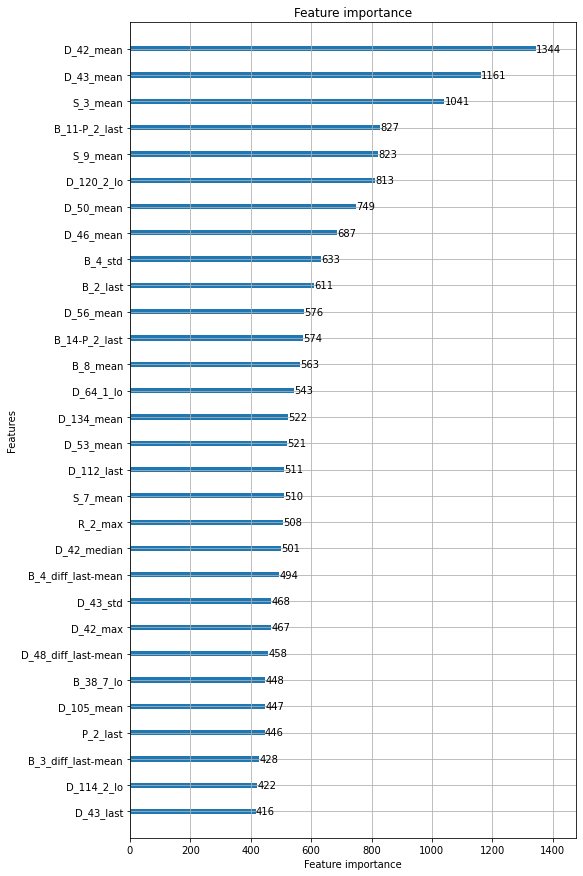

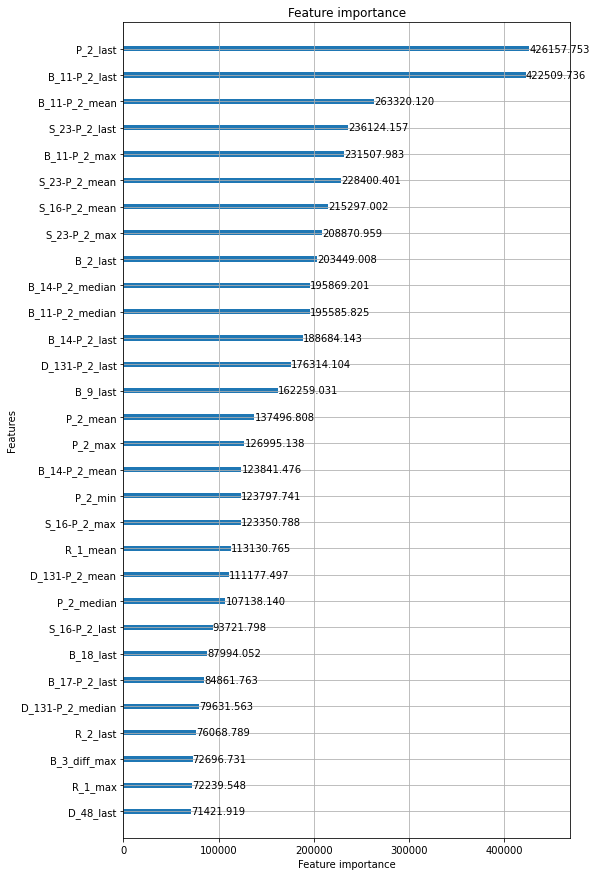

Training time: 211.83972097635268 min.
OOF recall_at4: 0.6707005082977077
OOF normalized_gini: 0.925829014950776
OOF competition metric: 0.7982647616242418


############################### repeated cross-validation step: 3/3 ################################


######################################## training model 1/5 ########################################


[50]	valid_0's amex_metric: 0.743094	valid_0's recall_at4: 0.588319	valid_0's norm_gini: 0.897869


[100]	valid_0's amex_metric: 0.753031	valid_0's recall_at4: 0.60292	valid_0's norm_gini: 0.903143


[150]	valid_0's amex_metric: 0.75874	valid_0's recall_at4: 0.61184	valid_0's norm_gini: 0.905639


[200]	valid_0's amex_metric: 0.76191	valid_0's recall_at4: 0.616721	valid_0's norm_gini: 0.907098


[250]	valid_0's amex_metric: 0.764823	valid_0's recall_at4: 0.620424	valid_0's norm_gini: 0.909221


[300]	valid_0's amex_metric: 0.767284	valid_0's recall_at4: 0.623874	valid_0's norm_gini: 0.910693


[350]	valid_0's amex_metric: 0.769193	valid_0's recall_at4: 0.626652	valid_0's norm_gini: 0.911735


[400]	valid_0's amex_metric: 0.771438	valid_0's recall_at4: 0.630354	valid_0's norm_gini: 0.912521


[450]	valid_0's amex_metric: 0.772835	valid_0's recall_at4: 0.631995	valid_0's norm_gini: 0.913674


[500]	valid_0's amex_metric: 0.77574	valid_0's recall_at4: 0.636582	valid_0's norm_gini: 0.914898


[550]	valid_0's amex_metric: 0.778083	valid_0's recall_at4: 0.640116	valid_0's norm_gini: 0.916049


[600]	valid_0's amex_metric: 0.779257	valid_0's recall_at4: 0.641631	valid_0's norm_gini: 0.916884


[650]	valid_0's amex_metric: 0.779939	valid_0's recall_at4: 0.642557	valid_0's norm_gini: 0.917322


[700]	valid_0's amex_metric: 0.781244	valid_0's recall_at4: 0.64466	valid_0's norm_gini: 0.917828


[750]	valid_0's amex_metric: 0.78202	valid_0's recall_at4: 0.645881	valid_0's norm_gini: 0.91816


[800]	valid_0's amex_metric: 0.782768	valid_0's recall_at4: 0.647059	valid_0's norm_gini: 0.918477


[850]	valid_0's amex_metric: 0.783095	valid_0's recall_at4: 0.647395	valid_0's norm_gini: 0.918795


[900]	valid_0's amex_metric: 0.784045	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.919096


[950]	valid_0's amex_metric: 0.784968	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.919469


[1000]	valid_0's amex_metric: 0.785658	valid_0's recall_at4: 0.651561	valid_0's norm_gini: 0.919756


[1050]	valid_0's amex_metric: 0.786536	valid_0's recall_at4: 0.65295	valid_0's norm_gini: 0.920122


[1100]	valid_0's amex_metric: 0.787231	valid_0's recall_at4: 0.654086	valid_0's norm_gini: 0.920376


[1150]	valid_0's amex_metric: 0.787165	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.920539


[1200]	valid_0's amex_metric: 0.787315	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.920712


[1250]	valid_0's amex_metric: 0.787368	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.920903


[1300]	valid_0's amex_metric: 0.788355	valid_0's recall_at4: 0.655769	valid_0's norm_gini: 0.920942


[1350]	valid_0's amex_metric: 0.788155	valid_0's recall_at4: 0.655264	valid_0's norm_gini: 0.921047


[1400]	valid_0's amex_metric: 0.788388	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.921218


[1450]	valid_0's amex_metric: 0.789268	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.921338


[1500]	valid_0's amex_metric: 0.789441	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.921472


[1550]	valid_0's amex_metric: 0.789306	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.921623


[1600]	valid_0's amex_metric: 0.789815	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.921758


[1650]	valid_0's amex_metric: 0.790174	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.921844


[1700]	valid_0's amex_metric: 0.79044	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.921913


[1750]	valid_0's amex_metric: 0.79111	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.922033


[1800]	valid_0's amex_metric: 0.791569	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.922151


[1850]	valid_0's amex_metric: 0.791428	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.922247


[1900]	valid_0's amex_metric: 0.791637	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.922287


[1950]	valid_0's amex_metric: 0.791473	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.922339


[2000]	valid_0's amex_metric: 0.791912	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.92246


[2050]	valid_0's amex_metric: 0.792647	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.922583


[2100]	valid_0's amex_metric: 0.792695	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.922678


[2150]	valid_0's amex_metric: 0.792621	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922782


[2200]	valid_0's amex_metric: 0.792719	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.922853


[2250]	valid_0's amex_metric: 0.793151	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.922876


[2300]	valid_0's amex_metric: 0.793256	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.922917


[2350]	valid_0's amex_metric: 0.793159	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.922976


[2400]	valid_0's amex_metric: 0.793021	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.923035


[2450]	valid_0's amex_metric: 0.793189	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923078


[2500]	valid_0's amex_metric: 0.793055	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.923146


[2550]	valid_0's amex_metric: 0.79308	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.923197


[2600]	valid_0's amex_metric: 0.793275	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.92325


[2650]	valid_0's amex_metric: 0.793357	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.923288


[2700]	valid_0's amex_metric: 0.793547	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.923331


[2750]	valid_0's amex_metric: 0.793604	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.92336


[2800]	valid_0's amex_metric: 0.794192	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923401


[2850]	valid_0's amex_metric: 0.793729	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.923442


[2900]	valid_0's amex_metric: 0.793786	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.923472


[2950]	valid_0's amex_metric: 0.793559	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.923481


[3000]	valid_0's amex_metric: 0.79402	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.923519


[3050]	valid_0's amex_metric: 0.793852	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923562


[3100]	valid_0's amex_metric: 0.793972	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923592


[3150]	valid_0's amex_metric: 0.794059	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.92364


[3200]	valid_0's amex_metric: 0.794151	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.923655


[3250]	valid_0's amex_metric: 0.794183	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.923677


[3300]	valid_0's amex_metric: 0.794489	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.923699


[3350]	valid_0's amex_metric: 0.794732	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.923724


[3400]	valid_0's amex_metric: 0.79466	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.923747


[3450]	valid_0's amex_metric: 0.794829	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.92379


[3500]	valid_0's amex_metric: 0.795068	valid_0's recall_at4: 0.66633	valid_0's norm_gini: 0.923807


[3550]	valid_0's amex_metric: 0.794864	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.923819


[3600]	valid_0's amex_metric: 0.794718	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.923822


[3650]	valid_0's amex_metric: 0.794902	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.923852


[3700]	valid_0's amex_metric: 0.794835	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.923888


[3750]	valid_0's amex_metric: 0.79487	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923915


[3800]	valid_0's amex_metric: 0.794864	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.923944


[3850]	valid_0's amex_metric: 0.794686	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.923967


[3900]	valid_0's amex_metric: 0.794879	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.923975


[3950]	valid_0's amex_metric: 0.794941	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924015


[4000]	valid_0's amex_metric: 0.795071	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924022


[4050]	valid_0's amex_metric: 0.795078	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924037


[4100]	valid_0's amex_metric: 0.795554	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.924064


[4150]	valid_0's amex_metric: 0.795157	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924068


[4200]	valid_0's amex_metric: 0.794818	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.924063


[4250]	valid_0's amex_metric: 0.7951	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.92408


[4300]	valid_0's amex_metric: 0.795462	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.92409


[4350]	valid_0's amex_metric: 0.795692	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.924127


[4400]	valid_0's amex_metric: 0.79555	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.924138


[4450]	valid_0's amex_metric: 0.795741	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.924142


[4500]	valid_0's amex_metric: 0.795564	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.924167


[4550]	valid_0's amex_metric: 0.79573	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.924204


[4600]	valid_0's amex_metric: 0.795586	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.92421


[4650]	valid_0's amex_metric: 0.795501	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.924209


[4700]	valid_0's amex_metric: 0.795649	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.924211


[4750]	valid_0's amex_metric: 0.795529	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.924223


[4800]	valid_0's amex_metric: 0.796241	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.924258


[4850]	valid_0's amex_metric: 0.796399	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.92428


[4900]	valid_0's amex_metric: 0.796553	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.924294


[4950]	valid_0's amex_metric: 0.796097	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.924307


[5000]	valid_0's amex_metric: 0.796454	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.924306


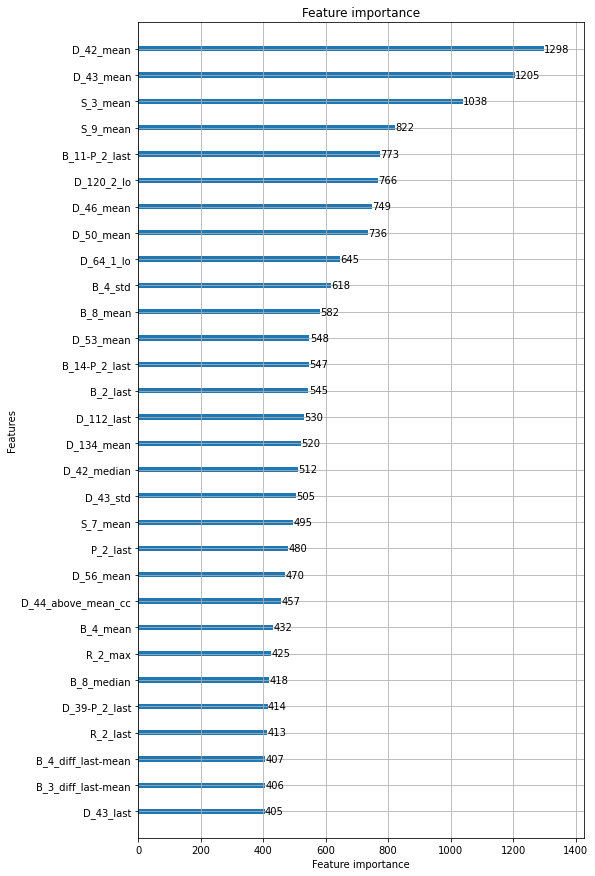

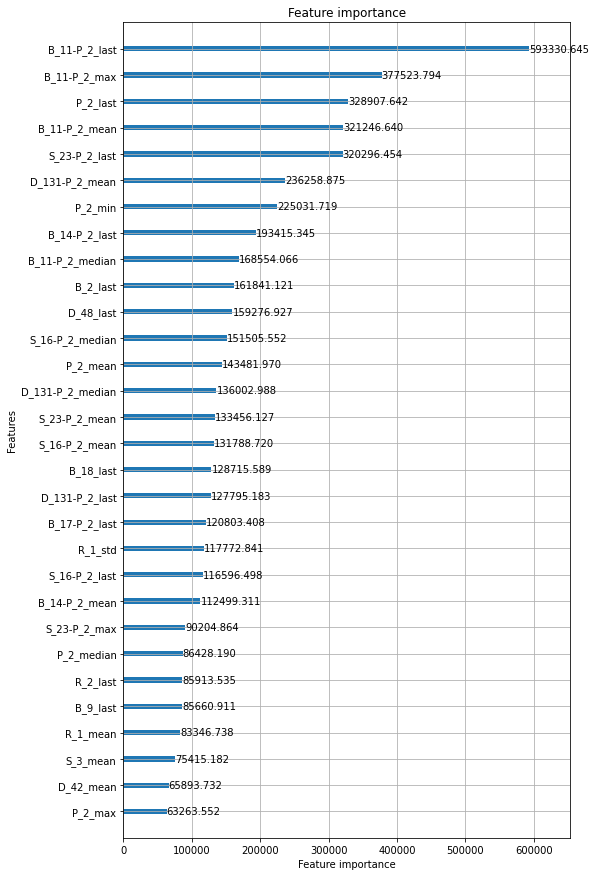

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.744893	valid_0's recall_at4: 0.590213	valid_0's norm_gini: 0.899572


[100]	valid_0's amex_metric: 0.751719	valid_0's recall_at4: 0.599344	valid_0's norm_gini: 0.904095


[150]	valid_0's amex_metric: 0.757799	valid_0's recall_at4: 0.608895	valid_0's norm_gini: 0.906703


[200]	valid_0's amex_metric: 0.761409	valid_0's recall_at4: 0.614491	valid_0's norm_gini: 0.908327


[250]	valid_0's amex_metric: 0.765179	valid_0's recall_at4: 0.620172	valid_0's norm_gini: 0.910186


[300]	valid_0's amex_metric: 0.767368	valid_0's recall_at4: 0.623075	valid_0's norm_gini: 0.911662


[350]	valid_0's amex_metric: 0.768351	valid_0's recall_at4: 0.624043	valid_0's norm_gini: 0.912659


[400]	valid_0's amex_metric: 0.769337	valid_0's recall_at4: 0.625221	valid_0's norm_gini: 0.913452


[450]	valid_0's amex_metric: 0.770954	valid_0's recall_at4: 0.627409	valid_0's norm_gini: 0.914499


[500]	valid_0's amex_metric: 0.772886	valid_0's recall_at4: 0.63006	valid_0's norm_gini: 0.915712


[550]	valid_0's amex_metric: 0.776432	valid_0's recall_at4: 0.635993	valid_0's norm_gini: 0.916871


[600]	valid_0's amex_metric: 0.778261	valid_0's recall_at4: 0.63877	valid_0's norm_gini: 0.917752


[650]	valid_0's amex_metric: 0.778845	valid_0's recall_at4: 0.639443	valid_0's norm_gini: 0.918247


[700]	valid_0's amex_metric: 0.779697	valid_0's recall_at4: 0.640579	valid_0's norm_gini: 0.918816


[750]	valid_0's amex_metric: 0.780723	valid_0's recall_at4: 0.642262	valid_0's norm_gini: 0.919183


[800]	valid_0's amex_metric: 0.781721	valid_0's recall_at4: 0.643903	valid_0's norm_gini: 0.919538


[850]	valid_0's amex_metric: 0.782898	valid_0's recall_at4: 0.645965	valid_0's norm_gini: 0.919832


[900]	valid_0's amex_metric: 0.78383	valid_0's recall_at4: 0.64748	valid_0's norm_gini: 0.92018


[950]	valid_0's amex_metric: 0.783928	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.920545


[1000]	valid_0's amex_metric: 0.785029	valid_0's recall_at4: 0.649247	valid_0's norm_gini: 0.920812


[1050]	valid_0's amex_metric: 0.784885	valid_0's recall_at4: 0.648574	valid_0's norm_gini: 0.921196


[1100]	valid_0's amex_metric: 0.785271	valid_0's recall_at4: 0.649078	valid_0's norm_gini: 0.921464


[1150]	valid_0's amex_metric: 0.785886	valid_0's recall_at4: 0.650088	valid_0's norm_gini: 0.921684


[1200]	valid_0's amex_metric: 0.78641	valid_0's recall_at4: 0.650972	valid_0's norm_gini: 0.921849


[1250]	valid_0's amex_metric: 0.786744	valid_0's recall_at4: 0.651393	valid_0's norm_gini: 0.922096


[1300]	valid_0's amex_metric: 0.786419	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.922161


[1350]	valid_0's amex_metric: 0.787129	valid_0's recall_at4: 0.65194	valid_0's norm_gini: 0.922319


[1400]	valid_0's amex_metric: 0.787622	valid_0's recall_at4: 0.652739	valid_0's norm_gini: 0.922505


[1450]	valid_0's amex_metric: 0.787657	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.922658


[1500]	valid_0's amex_metric: 0.78791	valid_0's recall_at4: 0.653034	valid_0's norm_gini: 0.922786


[1550]	valid_0's amex_metric: 0.788499	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.922953


[1600]	valid_0's amex_metric: 0.789232	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.923074


[1650]	valid_0's amex_metric: 0.789379	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.923199


[1700]	valid_0's amex_metric: 0.789171	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.923289


[1750]	valid_0's amex_metric: 0.789553	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.923379


[1800]	valid_0's amex_metric: 0.789678	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.923504


[1850]	valid_0's amex_metric: 0.790065	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.923604


[1900]	valid_0's amex_metric: 0.79016	valid_0's recall_at4: 0.656652	valid_0's norm_gini: 0.923667


[1950]	valid_0's amex_metric: 0.790171	valid_0's recall_at4: 0.65661	valid_0's norm_gini: 0.923732


[2000]	valid_0's amex_metric: 0.79033	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.923882


[2050]	valid_0's amex_metric: 0.790854	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.924003


[2100]	valid_0's amex_metric: 0.791068	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.924096


[2150]	valid_0's amex_metric: 0.791219	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.924187


[2200]	valid_0's amex_metric: 0.791268	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.924285


[2250]	valid_0's amex_metric: 0.791716	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.924338


[2300]	valid_0's amex_metric: 0.791439	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.924375


[2350]	valid_0's amex_metric: 0.791632	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.924425


[2400]	valid_0's amex_metric: 0.791626	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.924454


[2450]	valid_0's amex_metric: 0.791708	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.924491


[2500]	valid_0's amex_metric: 0.791569	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.92455


[2550]	valid_0's amex_metric: 0.792047	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.924581


[2600]	valid_0's amex_metric: 0.792158	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924592


[2650]	valid_0's amex_metric: 0.792056	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.92464


[2700]	valid_0's amex_metric: 0.79215	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.924703


[2750]	valid_0's amex_metric: 0.792323	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.924711


[2800]	valid_0's amex_metric: 0.792221	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.92476


[2850]	valid_0's amex_metric: 0.792425	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.924789


[2900]	valid_0's amex_metric: 0.793014	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.924832


[2950]	valid_0's amex_metric: 0.792814	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924853


[3000]	valid_0's amex_metric: 0.792988	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.924906


[3050]	valid_0's amex_metric: 0.792641	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.924926


[3100]	valid_0's amex_metric: 0.792465	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.924953


[3150]	valid_0's amex_metric: 0.792988	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.92499


[3200]	valid_0's amex_metric: 0.793105	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.925055


[3250]	valid_0's amex_metric: 0.792802	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.925081


[3300]	valid_0's amex_metric: 0.792995	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.925131


[3350]	valid_0's amex_metric: 0.792966	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.925157


[3400]	valid_0's amex_metric: 0.792702	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.925175


[3450]	valid_0's amex_metric: 0.79299	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.925205


[3500]	valid_0's amex_metric: 0.792822	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.925205


[3550]	valid_0's amex_metric: 0.793042	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.925224


[3600]	valid_0's amex_metric: 0.793028	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.925238


[3650]	valid_0's amex_metric: 0.793201	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.925289


[3700]	valid_0's amex_metric: 0.793341	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.925317


[3750]	valid_0's amex_metric: 0.793479	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.92534


[3800]	valid_0's amex_metric: 0.79366	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.925367


[3850]	valid_0's amex_metric: 0.7939	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.925384


[3900]	valid_0's amex_metric: 0.793782	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.925399


[3950]	valid_0's amex_metric: 0.794043	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.925417


[4000]	valid_0's amex_metric: 0.793856	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.92542


[4050]	valid_0's amex_metric: 0.793748	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.925458


[4100]	valid_0's amex_metric: 0.793427	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.925488


[4150]	valid_0's amex_metric: 0.79366	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.925534


[4200]	valid_0's amex_metric: 0.793584	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.92555


[4250]	valid_0's amex_metric: 0.793831	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.925582


[4300]	valid_0's amex_metric: 0.793777	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.925599


[4350]	valid_0's amex_metric: 0.79374	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.925611


[4400]	valid_0's amex_metric: 0.793971	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.925652


[4450]	valid_0's amex_metric: 0.793832	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.925668


[4500]	valid_0's amex_metric: 0.793646	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925674


[4550]	valid_0's amex_metric: 0.793904	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.925685


[4600]	valid_0's amex_metric: 0.793736	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.925686


[4650]	valid_0's amex_metric: 0.793782	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.925694


[4700]	valid_0's amex_metric: 0.793659	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925701


[4750]	valid_0's amex_metric: 0.793734	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.925724


[4800]	valid_0's amex_metric: 0.793781	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.925735


[4850]	valid_0's amex_metric: 0.793914	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.925747


[4900]	valid_0's amex_metric: 0.793793	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.925758


[4950]	valid_0's amex_metric: 0.793818	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.925767


[5000]	valid_0's amex_metric: 0.793695	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925773


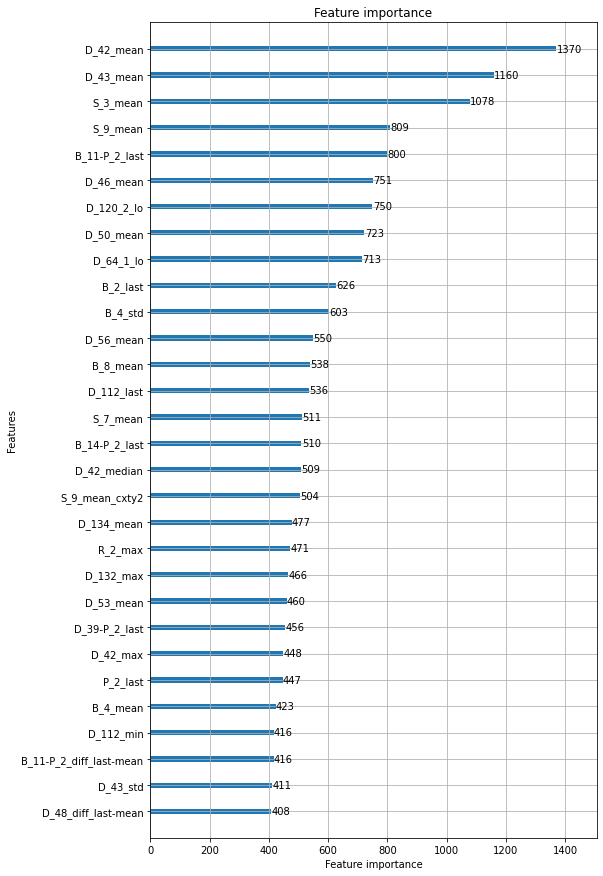

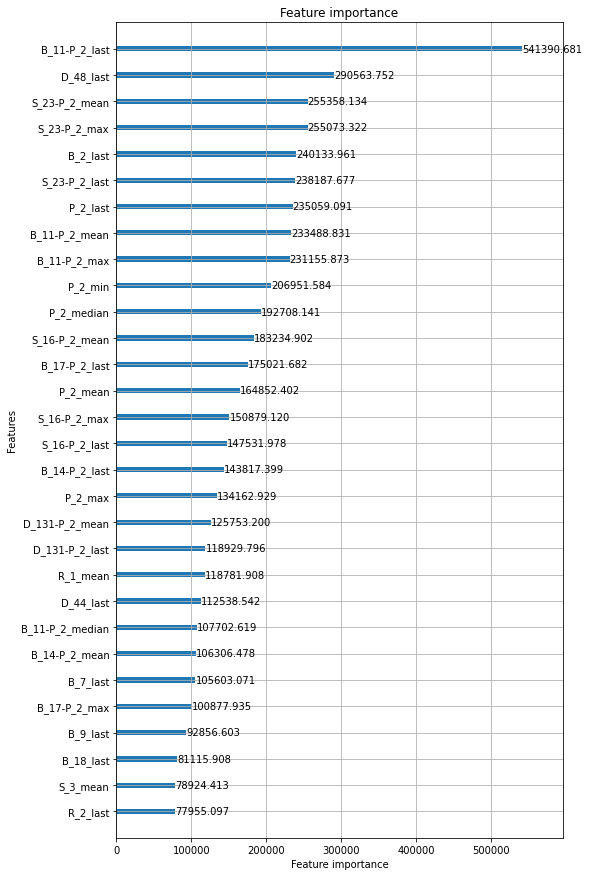

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.745402	valid_0's recall_at4: 0.593242	valid_0's norm_gini: 0.897562


[100]	valid_0's amex_metric: 0.756381	valid_0's recall_at4: 0.609989	valid_0's norm_gini: 0.902773


[150]	valid_0's amex_metric: 0.762846	valid_0's recall_at4: 0.619793	valid_0's norm_gini: 0.905898


[200]	valid_0's amex_metric: 0.764605	valid_0's recall_at4: 0.621644	valid_0's norm_gini: 0.907566


[250]	valid_0's amex_metric: 0.76864	valid_0's recall_at4: 0.627746	valid_0's norm_gini: 0.909534


[300]	valid_0's amex_metric: 0.771331	valid_0's recall_at4: 0.631322	valid_0's norm_gini: 0.911339


[350]	valid_0's amex_metric: 0.774312	valid_0's recall_at4: 0.636161	valid_0's norm_gini: 0.912463


[400]	valid_0's amex_metric: 0.775851	valid_0's recall_at4: 0.638433	valid_0's norm_gini: 0.913269


[450]	valid_0's amex_metric: 0.778135	valid_0's recall_at4: 0.641925	valid_0's norm_gini: 0.914344


[500]	valid_0's amex_metric: 0.779387	valid_0's recall_at4: 0.643146	valid_0's norm_gini: 0.915628


[550]	valid_0's amex_metric: 0.782527	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.916902


[600]	valid_0's amex_metric: 0.784078	valid_0's recall_at4: 0.650257	valid_0's norm_gini: 0.917899


[650]	valid_0's amex_metric: 0.786038	valid_0's recall_at4: 0.653665	valid_0's norm_gini: 0.918411


[700]	valid_0's amex_metric: 0.787187	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.918983


[750]	valid_0's amex_metric: 0.788274	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.919348


[800]	valid_0's amex_metric: 0.788161	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.919753


[850]	valid_0's amex_metric: 0.788518	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.920131


[900]	valid_0's amex_metric: 0.78991	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.920433


[950]	valid_0's amex_metric: 0.790638	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.920879


[1000]	valid_0's amex_metric: 0.790675	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.921205


[1050]	valid_0's amex_metric: 0.791897	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.92163


[1100]	valid_0's amex_metric: 0.792193	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.921885


[1150]	valid_0's amex_metric: 0.792202	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.922071


[1200]	valid_0's amex_metric: 0.792467	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.922265


[1250]	valid_0's amex_metric: 0.793185	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.922522


[1300]	valid_0's amex_metric: 0.793218	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.922547


[1350]	valid_0's amex_metric: 0.793091	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.922671


[1400]	valid_0's amex_metric: 0.793931	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.922878


[1450]	valid_0's amex_metric: 0.793978	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.923014


[1500]	valid_0's amex_metric: 0.793375	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.923155


[1550]	valid_0's amex_metric: 0.794134	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.923326


[1600]	valid_0's amex_metric: 0.795059	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.923493


[1650]	valid_0's amex_metric: 0.794784	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.923617


[1700]	valid_0's amex_metric: 0.795567	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.923709


[1750]	valid_0's amex_metric: 0.795203	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.923823


[1800]	valid_0's amex_metric: 0.795262	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.9239


[1850]	valid_0's amex_metric: 0.795342	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924017


[1900]	valid_0's amex_metric: 0.795411	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924072


[1950]	valid_0's amex_metric: 0.796035	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.92414


[2000]	valid_0's amex_metric: 0.795626	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.924292


[2050]	valid_0's amex_metric: 0.796315	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.924407


[2100]	valid_0's amex_metric: 0.796277	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.924498


[2150]	valid_0's amex_metric: 0.79657	valid_0's recall_at4: 0.66856	valid_0's norm_gini: 0.924579


[2200]	valid_0's amex_metric: 0.797091	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.924654


[2250]	valid_0's amex_metric: 0.796965	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924738


[2300]	valid_0's amex_metric: 0.797441	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.924764


[2350]	valid_0's amex_metric: 0.797759	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.924812


[2400]	valid_0's amex_metric: 0.797887	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.924857


[2450]	valid_0's amex_metric: 0.798047	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.924884


[2500]	valid_0's amex_metric: 0.798134	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.924931


[2550]	valid_0's amex_metric: 0.798216	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.924969


[2600]	valid_0's amex_metric: 0.798102	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925036


[2650]	valid_0's amex_metric: 0.798438	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.925075


[2700]	valid_0's amex_metric: 0.798369	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925149


[2750]	valid_0's amex_metric: 0.797906	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925191


[2800]	valid_0's amex_metric: 0.798074	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925232


[2850]	valid_0's amex_metric: 0.798298	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.92526


[2900]	valid_0's amex_metric: 0.798077	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925279


[2950]	valid_0's amex_metric: 0.798233	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925297


[3000]	valid_0's amex_metric: 0.798666	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925321


[3050]	valid_0's amex_metric: 0.79896	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925362


[3100]	valid_0's amex_metric: 0.799479	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.92539


[3150]	valid_0's amex_metric: 0.798929	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.925427


[3200]	valid_0's amex_metric: 0.799341	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.925451


[3250]	valid_0's amex_metric: 0.799442	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925486


[3300]	valid_0's amex_metric: 0.799127	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.925529


[3350]	valid_0's amex_metric: 0.799054	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92555


[3400]	valid_0's amex_metric: 0.799481	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925562


[3450]	valid_0's amex_metric: 0.79893	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925597


[3500]	valid_0's amex_metric: 0.798767	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925607


[3550]	valid_0's amex_metric: 0.798848	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925644


[3600]	valid_0's amex_metric: 0.79831	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925661


[3650]	valid_0's amex_metric: 0.79868	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925685


[3700]	valid_0's amex_metric: 0.798938	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925698


[3750]	valid_0's amex_metric: 0.798485	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.925717


[3800]	valid_0's amex_metric: 0.798635	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.925723


[3850]	valid_0's amex_metric: 0.799147	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925738


[3900]	valid_0's amex_metric: 0.799288	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.925767


[3950]	valid_0's amex_metric: 0.799397	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925774


[4000]	valid_0's amex_metric: 0.799023	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925784


[4050]	valid_0's amex_metric: 0.798854	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925823


[4100]	valid_0's amex_metric: 0.798949	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925846


[4150]	valid_0's amex_metric: 0.799277	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.92587


[4200]	valid_0's amex_metric: 0.799031	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925883


[4250]	valid_0's amex_metric: 0.799075	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925888


[4300]	valid_0's amex_metric: 0.798678	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925893


[4350]	valid_0's amex_metric: 0.799163	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.925895


[4400]	valid_0's amex_metric: 0.79912	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925934


[4450]	valid_0's amex_metric: 0.799085	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925949


[4500]	valid_0's amex_metric: 0.799575	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925961


[4550]	valid_0's amex_metric: 0.799555	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.925963


[4600]	valid_0's amex_metric: 0.799345	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.925964


[4650]	valid_0's amex_metric: 0.799278	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.925956


[4700]	valid_0's amex_metric: 0.799552	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.925957


[4750]	valid_0's amex_metric: 0.7995	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.92598


[4800]	valid_0's amex_metric: 0.799349	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.925973


[4850]	valid_0's amex_metric: 0.79952	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.925978


[4900]	valid_0's amex_metric: 0.799019	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925985


[4950]	valid_0's amex_metric: 0.799277	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925996


[5000]	valid_0's amex_metric: 0.799269	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926023


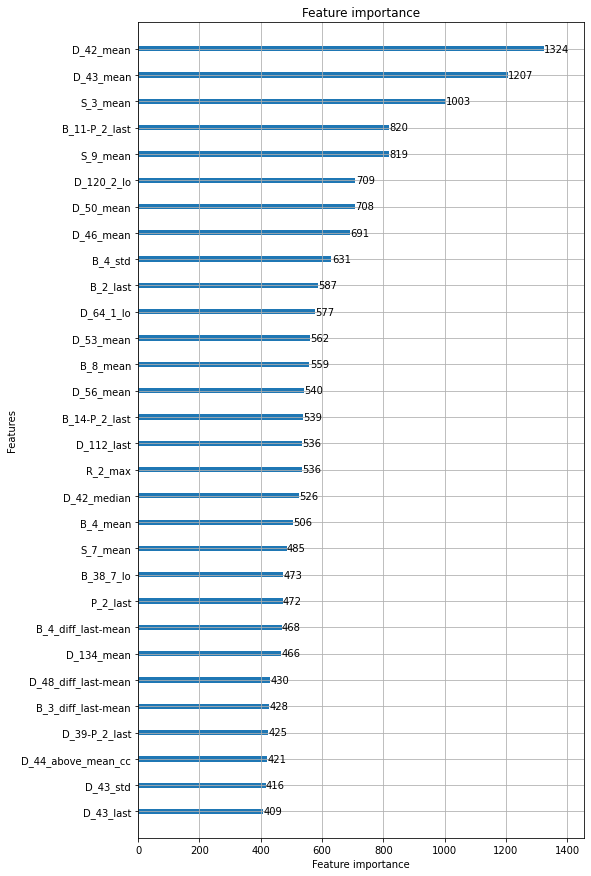

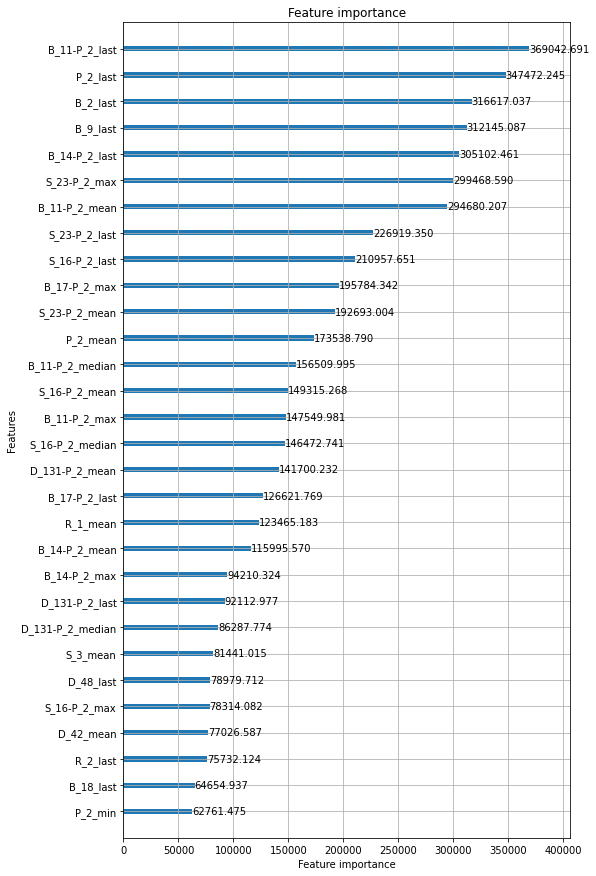

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.752455	valid_0's recall_at4: 0.602777	valid_0's norm_gini: 0.902133


[100]	valid_0's amex_metric: 0.761248	valid_0's recall_at4: 0.615443	valid_0's norm_gini: 0.907053


[150]	valid_0's amex_metric: 0.7651	valid_0's recall_at4: 0.620661	valid_0's norm_gini: 0.90954


[200]	valid_0's amex_metric: 0.768521	valid_0's recall_at4: 0.62592	valid_0's norm_gini: 0.911122


[250]	valid_0's amex_metric: 0.772705	valid_0's recall_at4: 0.632274	valid_0's norm_gini: 0.913136


[300]	valid_0's amex_metric: 0.776506	valid_0's recall_at4: 0.638207	valid_0's norm_gini: 0.914805


[350]	valid_0's amex_metric: 0.777584	valid_0's recall_at4: 0.639344	valid_0's norm_gini: 0.915824


[400]	valid_0's amex_metric: 0.778915	valid_0's recall_at4: 0.641237	valid_0's norm_gini: 0.916593


[450]	valid_0's amex_metric: 0.780696	valid_0's recall_at4: 0.643678	valid_0's norm_gini: 0.917714


[500]	valid_0's amex_metric: 0.783158	valid_0's recall_at4: 0.647254	valid_0's norm_gini: 0.919061


[550]	valid_0's amex_metric: 0.786768	valid_0's recall_at4: 0.65344	valid_0's norm_gini: 0.920097


[600]	valid_0's amex_metric: 0.788469	valid_0's recall_at4: 0.655923	valid_0's norm_gini: 0.921016


[650]	valid_0's amex_metric: 0.789006	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.921416


[700]	valid_0's amex_metric: 0.790509	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.921939


[750]	valid_0's amex_metric: 0.791723	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.922306


[800]	valid_0's amex_metric: 0.792457	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.92268


[850]	valid_0's amex_metric: 0.793533	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.922979


[900]	valid_0's amex_metric: 0.794189	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.923281


[950]	valid_0's amex_metric: 0.795049	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.923656


[1000]	valid_0's amex_metric: 0.796413	valid_0's recall_at4: 0.668799	valid_0's norm_gini: 0.924027


[1050]	valid_0's amex_metric: 0.79683	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.92444


[1100]	valid_0's amex_metric: 0.797555	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.92467


[1150]	valid_0's amex_metric: 0.798069	valid_0's recall_at4: 0.671281	valid_0's norm_gini: 0.924857


[1200]	valid_0's amex_metric: 0.798213	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.925018


[1250]	valid_0's amex_metric: 0.798215	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.925233


[1300]	valid_0's amex_metric: 0.79784	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925283


[1350]	valid_0's amex_metric: 0.79901	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925434


[1400]	valid_0's amex_metric: 0.79941	valid_0's recall_at4: 0.673175	valid_0's norm_gini: 0.925644


[1450]	valid_0's amex_metric: 0.799714	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.925789


[1500]	valid_0's amex_metric: 0.799675	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.925923


[1550]	valid_0's amex_metric: 0.799873	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.926109


[1600]	valid_0's amex_metric: 0.800487	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.926201


[1650]	valid_0's amex_metric: 0.80074	valid_0's recall_at4: 0.675153	valid_0's norm_gini: 0.926328


[1700]	valid_0's amex_metric: 0.80124	valid_0's recall_at4: 0.676036	valid_0's norm_gini: 0.926444


[1750]	valid_0's amex_metric: 0.801673	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.926552


[1800]	valid_0's amex_metric: 0.8017	valid_0's recall_at4: 0.676752	valid_0's norm_gini: 0.926649


[1850]	valid_0's amex_metric: 0.801984	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.926753


[1900]	valid_0's amex_metric: 0.801919	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.926791


[1950]	valid_0's amex_metric: 0.802253	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.926871


[2000]	valid_0's amex_metric: 0.801884	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.926974


[2050]	valid_0's amex_metric: 0.802406	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.927093


[2100]	valid_0's amex_metric: 0.802292	valid_0's recall_at4: 0.677383	valid_0's norm_gini: 0.927202


[2150]	valid_0's amex_metric: 0.802358	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927292


[2200]	valid_0's amex_metric: 0.802606	valid_0's recall_at4: 0.677846	valid_0's norm_gini: 0.927367


[2250]	valid_0's amex_metric: 0.802504	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.927414


[2300]	valid_0's amex_metric: 0.802618	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.927433


[2350]	valid_0's amex_metric: 0.802959	valid_0's recall_at4: 0.678435	valid_0's norm_gini: 0.927484


[2400]	valid_0's amex_metric: 0.802664	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.927566


[2450]	valid_0's amex_metric: 0.802566	valid_0's recall_at4: 0.677509	valid_0's norm_gini: 0.927624


[2500]	valid_0's amex_metric: 0.802642	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927649


[2550]	valid_0's amex_metric: 0.802746	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.927689


[2600]	valid_0's amex_metric: 0.802753	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.927745


[2650]	valid_0's amex_metric: 0.803227	valid_0's recall_at4: 0.678645	valid_0's norm_gini: 0.927809


[2700]	valid_0's amex_metric: 0.803301	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.927872


[2750]	valid_0's amex_metric: 0.803658	valid_0's recall_at4: 0.679402	valid_0's norm_gini: 0.927914


[2800]	valid_0's amex_metric: 0.803175	valid_0's recall_at4: 0.678393	valid_0's norm_gini: 0.927957


[2850]	valid_0's amex_metric: 0.80342	valid_0's recall_at4: 0.678813	valid_0's norm_gini: 0.928027


[2900]	valid_0's amex_metric: 0.803255	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928032


[2950]	valid_0's amex_metric: 0.80311	valid_0's recall_at4: 0.678182	valid_0's norm_gini: 0.928038


[3000]	valid_0's amex_metric: 0.803397	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.928065


[3050]	valid_0's amex_metric: 0.803516	valid_0's recall_at4: 0.67894	valid_0's norm_gini: 0.928092


[3100]	valid_0's amex_metric: 0.803826	valid_0's recall_at4: 0.679529	valid_0's norm_gini: 0.928123


[3150]	valid_0's amex_metric: 0.803759	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.928199


[3200]	valid_0's amex_metric: 0.803407	valid_0's recall_at4: 0.678603	valid_0's norm_gini: 0.928212


[3250]	valid_0's amex_metric: 0.804119	valid_0's recall_at4: 0.67995	valid_0's norm_gini: 0.928288


[3300]	valid_0's amex_metric: 0.80382	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.928322


[3350]	valid_0's amex_metric: 0.803555	valid_0's recall_at4: 0.678771	valid_0's norm_gini: 0.928338


[3400]	valid_0's amex_metric: 0.803734	valid_0's recall_at4: 0.679108	valid_0's norm_gini: 0.928361


[3450]	valid_0's amex_metric: 0.803866	valid_0's recall_at4: 0.67936	valid_0's norm_gini: 0.928371


[3500]	valid_0's amex_metric: 0.803673	valid_0's recall_at4: 0.67894	valid_0's norm_gini: 0.928406


[3550]	valid_0's amex_metric: 0.804017	valid_0's recall_at4: 0.679613	valid_0's norm_gini: 0.928421


[3600]	valid_0's amex_metric: 0.804112	valid_0's recall_at4: 0.679781	valid_0's norm_gini: 0.928443


[3650]	valid_0's amex_metric: 0.804154	valid_0's recall_at4: 0.679823	valid_0's norm_gini: 0.928485


[3700]	valid_0's amex_metric: 0.804185	valid_0's recall_at4: 0.679865	valid_0's norm_gini: 0.928504


[3750]	valid_0's amex_metric: 0.803766	valid_0's recall_at4: 0.679024	valid_0's norm_gini: 0.928507


[3800]	valid_0's amex_metric: 0.804074	valid_0's recall_at4: 0.679613	valid_0's norm_gini: 0.928536


[3850]	valid_0's amex_metric: 0.804	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.928555


[3900]	valid_0's amex_metric: 0.803795	valid_0's recall_at4: 0.679024	valid_0's norm_gini: 0.928567


[3950]	valid_0's amex_metric: 0.804012	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.92858


[4000]	valid_0's amex_metric: 0.804012	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.92858


[4050]	valid_0's amex_metric: 0.804372	valid_0's recall_at4: 0.680118	valid_0's norm_gini: 0.928626


[4100]	valid_0's amex_metric: 0.804246	valid_0's recall_at4: 0.679865	valid_0's norm_gini: 0.928627


[4150]	valid_0's amex_metric: 0.804001	valid_0's recall_at4: 0.67936	valid_0's norm_gini: 0.928642


[4200]	valid_0's amex_metric: 0.804558	valid_0's recall_at4: 0.680454	valid_0's norm_gini: 0.928662


[4250]	valid_0's amex_metric: 0.804261	valid_0's recall_at4: 0.679865	valid_0's norm_gini: 0.928657


[4300]	valid_0's amex_metric: 0.804517	valid_0's recall_at4: 0.68037	valid_0's norm_gini: 0.928664


[4350]	valid_0's amex_metric: 0.804397	valid_0's recall_at4: 0.680118	valid_0's norm_gini: 0.928676


[4400]	valid_0's amex_metric: 0.804408	valid_0's recall_at4: 0.680118	valid_0's norm_gini: 0.928699


[4450]	valid_0's amex_metric: 0.804289	valid_0's recall_at4: 0.679865	valid_0's norm_gini: 0.928714


[4500]	valid_0's amex_metric: 0.804211	valid_0's recall_at4: 0.679697	valid_0's norm_gini: 0.928725


[4550]	valid_0's amex_metric: 0.804662	valid_0's recall_at4: 0.680581	valid_0's norm_gini: 0.928744


[4600]	valid_0's amex_metric: 0.804463	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.928766


[4650]	valid_0's amex_metric: 0.804208	valid_0's recall_at4: 0.679655	valid_0's norm_gini: 0.928761


[4700]	valid_0's amex_metric: 0.804427	valid_0's recall_at4: 0.680076	valid_0's norm_gini: 0.928778


[4750]	valid_0's amex_metric: 0.804745	valid_0's recall_at4: 0.680707	valid_0's norm_gini: 0.928783


[4800]	valid_0's amex_metric: 0.804634	valid_0's recall_at4: 0.680454	valid_0's norm_gini: 0.928814


[4850]	valid_0's amex_metric: 0.804595	valid_0's recall_at4: 0.68037	valid_0's norm_gini: 0.92882


[4900]	valid_0's amex_metric: 0.804806	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.928821


[4950]	valid_0's amex_metric: 0.804561	valid_0's recall_at4: 0.680286	valid_0's norm_gini: 0.928837


[5000]	valid_0's amex_metric: 0.804585	valid_0's recall_at4: 0.680328	valid_0's norm_gini: 0.928842


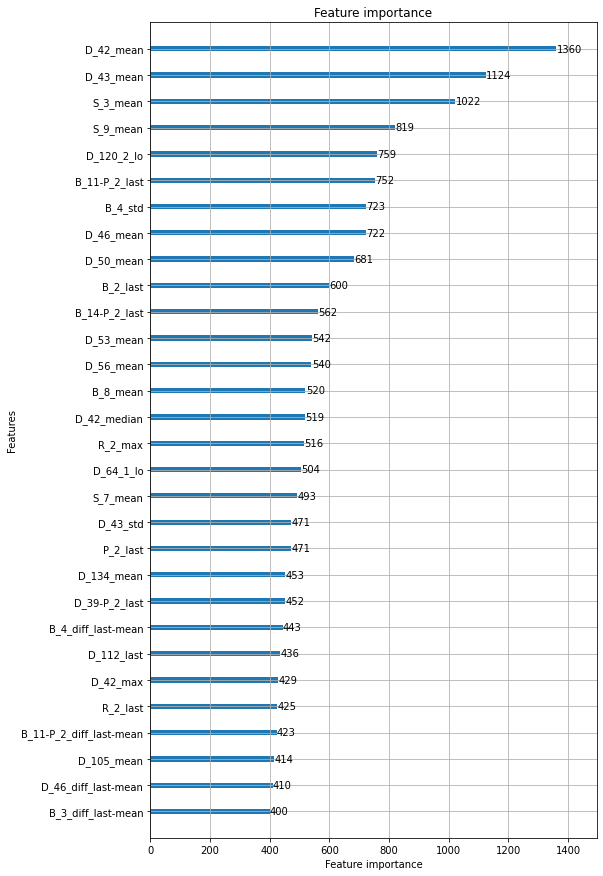

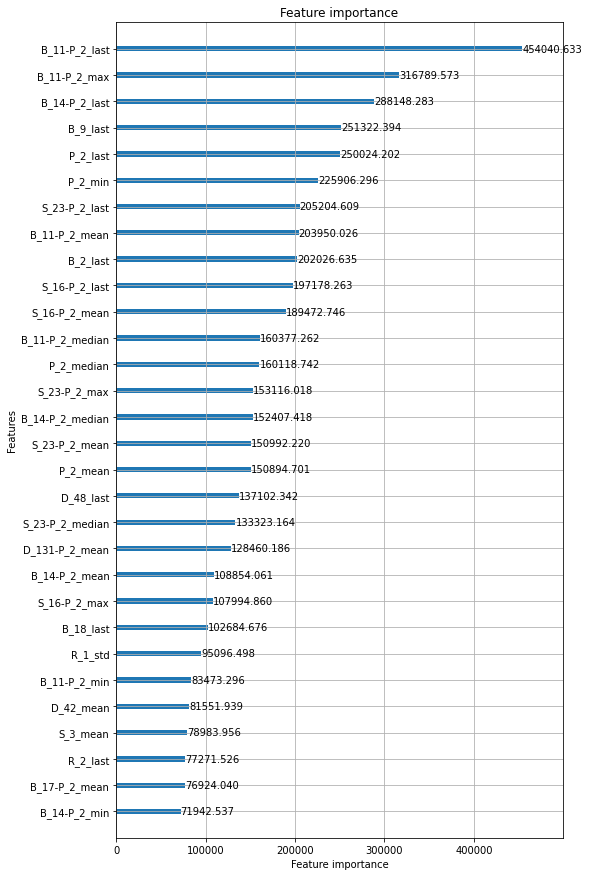

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.745882	valid_0's recall_at4: 0.593267	valid_0's norm_gini: 0.898497


[100]	valid_0's amex_metric: 0.756801	valid_0's recall_at4: 0.609804	valid_0's norm_gini: 0.903798


[150]	valid_0's amex_metric: 0.761034	valid_0's recall_at4: 0.616032	valid_0's norm_gini: 0.906036


[200]	valid_0's amex_metric: 0.76513	valid_0's recall_at4: 0.622175	valid_0's norm_gini: 0.908084


[250]	valid_0's amex_metric: 0.768192	valid_0's recall_at4: 0.62651	valid_0's norm_gini: 0.909875


[300]	valid_0's amex_metric: 0.770767	valid_0's recall_at4: 0.62996	valid_0's norm_gini: 0.911575


[350]	valid_0's amex_metric: 0.773165	valid_0's recall_at4: 0.633747	valid_0's norm_gini: 0.912582


[400]	valid_0's amex_metric: 0.774172	valid_0's recall_at4: 0.635094	valid_0's norm_gini: 0.91325


[450]	valid_0's amex_metric: 0.775704	valid_0's recall_at4: 0.637155	valid_0's norm_gini: 0.914253


[500]	valid_0's amex_metric: 0.779082	valid_0's recall_at4: 0.642584	valid_0's norm_gini: 0.91558


[550]	valid_0's amex_metric: 0.780981	valid_0's recall_at4: 0.645403	valid_0's norm_gini: 0.916559


[600]	valid_0's amex_metric: 0.781625	valid_0's recall_at4: 0.645782	valid_0's norm_gini: 0.917467


[650]	valid_0's amex_metric: 0.782634	valid_0's recall_at4: 0.647423	valid_0's norm_gini: 0.917845


[700]	valid_0's amex_metric: 0.78338	valid_0's recall_at4: 0.648433	valid_0's norm_gini: 0.918328


[750]	valid_0's amex_metric: 0.78363	valid_0's recall_at4: 0.648601	valid_0's norm_gini: 0.91866


[800]	valid_0's amex_metric: 0.785308	valid_0's recall_at4: 0.651546	valid_0's norm_gini: 0.919071


[850]	valid_0's amex_metric: 0.785513	valid_0's recall_at4: 0.651631	valid_0's norm_gini: 0.919396


[900]	valid_0's amex_metric: 0.786531	valid_0's recall_at4: 0.653356	valid_0's norm_gini: 0.919706


[950]	valid_0's amex_metric: 0.78705	valid_0's recall_at4: 0.654029	valid_0's norm_gini: 0.920071


[1000]	valid_0's amex_metric: 0.787297	valid_0's recall_at4: 0.654281	valid_0's norm_gini: 0.920312


[1050]	valid_0's amex_metric: 0.788075	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.920689


[1100]	valid_0's amex_metric: 0.787723	valid_0's recall_at4: 0.654492	valid_0's norm_gini: 0.920955


[1150]	valid_0's amex_metric: 0.788062	valid_0's recall_at4: 0.654955	valid_0's norm_gini: 0.921169


[1200]	valid_0's amex_metric: 0.788176	valid_0's recall_at4: 0.655039	valid_0's norm_gini: 0.921313


[1250]	valid_0's amex_metric: 0.788646	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921538


[1300]	valid_0's amex_metric: 0.788668	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921582


[1350]	valid_0's amex_metric: 0.789288	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.921729


[1400]	valid_0's amex_metric: 0.789506	valid_0's recall_at4: 0.657101	valid_0's norm_gini: 0.921911


[1450]	valid_0's amex_metric: 0.789823	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.922083


[1500]	valid_0's amex_metric: 0.78984	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.922202


[1550]	valid_0's amex_metric: 0.789963	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.922362


[1600]	valid_0's amex_metric: 0.79007	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.922493


[1650]	valid_0's amex_metric: 0.790271	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.9226


[1700]	valid_0's amex_metric: 0.790808	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.922664


[1750]	valid_0's amex_metric: 0.791067	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.922761


[1800]	valid_0's amex_metric: 0.791201	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.922902


[1850]	valid_0's amex_metric: 0.791454	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.922988


[1900]	valid_0's amex_metric: 0.790975	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.92304


[1950]	valid_0's amex_metric: 0.791426	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.9231


[2000]	valid_0's amex_metric: 0.791416	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.923207


[2050]	valid_0's amex_metric: 0.791331	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.923289


[2100]	valid_0's amex_metric: 0.791361	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.923392


[2150]	valid_0's amex_metric: 0.791421	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.92347


[2200]	valid_0's amex_metric: 0.791708	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.923539


[2250]	valid_0's amex_metric: 0.792605	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.923607


[2300]	valid_0's amex_metric: 0.792748	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.92364


[2350]	valid_0's amex_metric: 0.792835	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.923687


[2400]	valid_0's amex_metric: 0.792807	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.923716


[2450]	valid_0's amex_metric: 0.792951	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.923752


[2500]	valid_0's amex_metric: 0.793036	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.923795


[2550]	valid_0's amex_metric: 0.793787	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.923825


[2600]	valid_0's amex_metric: 0.79334	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.923899


[2650]	valid_0's amex_metric: 0.793649	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.923927


[2700]	valid_0's amex_metric: 0.794055	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.923981


[2750]	valid_0's amex_metric: 0.794279	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.92401


[2800]	valid_0's amex_metric: 0.794443	valid_0's recall_at4: 0.664843	valid_0's norm_gini: 0.924042


[2850]	valid_0's amex_metric: 0.794318	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924086


[2900]	valid_0's amex_metric: 0.794159	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.924105


[2950]	valid_0's amex_metric: 0.794256	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.924131


[3000]	valid_0's amex_metric: 0.793956	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.924163


[3050]	valid_0's amex_metric: 0.794489	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.924177


[3100]	valid_0's amex_metric: 0.794225	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924196


[3150]	valid_0's amex_metric: 0.794376	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924245


[3200]	valid_0's amex_metric: 0.794302	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924265


[3250]	valid_0's amex_metric: 0.794416	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924284


[3300]	valid_0's amex_metric: 0.794664	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924317


[3350]	valid_0's amex_metric: 0.794482	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.924331


[3400]	valid_0's amex_metric: 0.794252	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924333


[3450]	valid_0's amex_metric: 0.794922	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.92437


[3500]	valid_0's amex_metric: 0.794424	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.924383


[3550]	valid_0's amex_metric: 0.794891	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924391


[3600]	valid_0's amex_metric: 0.794548	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.92442


[3650]	valid_0's amex_metric: 0.794583	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.924448


[3700]	valid_0's amex_metric: 0.79472	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.924471


[3750]	valid_0's amex_metric: 0.794773	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.924491


[3800]	valid_0's amex_metric: 0.795037	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.924516


[3850]	valid_0's amex_metric: 0.794945	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.924542


[3900]	valid_0's amex_metric: 0.795196	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924539


[3950]	valid_0's amex_metric: 0.794615	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924555


[4000]	valid_0's amex_metric: 0.794601	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.92457


[4050]	valid_0's amex_metric: 0.795099	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.924597


[4100]	valid_0's amex_metric: 0.794853	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.924611


[4150]	valid_0's amex_metric: 0.795002	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924614


[4200]	valid_0's amex_metric: 0.795104	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.924607


[4250]	valid_0's amex_metric: 0.794795	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.924621


[4300]	valid_0's amex_metric: 0.794965	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.924624


[4350]	valid_0's amex_metric: 0.794906	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.924632


[4400]	valid_0's amex_metric: 0.79487	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.924645


[4450]	valid_0's amex_metric: 0.795128	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.924656


[4500]	valid_0's amex_metric: 0.795622	valid_0's recall_at4: 0.666568	valid_0's norm_gini: 0.924675


[4550]	valid_0's amex_metric: 0.795453	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.924675


[4600]	valid_0's amex_metric: 0.795119	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.924679


[4650]	valid_0's amex_metric: 0.795604	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.924682


[4700]	valid_0's amex_metric: 0.795273	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924694


[4750]	valid_0's amex_metric: 0.795364	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.924707


[4800]	valid_0's amex_metric: 0.795206	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.924728


[4850]	valid_0's amex_metric: 0.795587	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.924732


[4900]	valid_0's amex_metric: 0.795549	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.92474


[4950]	valid_0's amex_metric: 0.795636	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.924745


[5000]	valid_0's amex_metric: 0.795576	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.924752


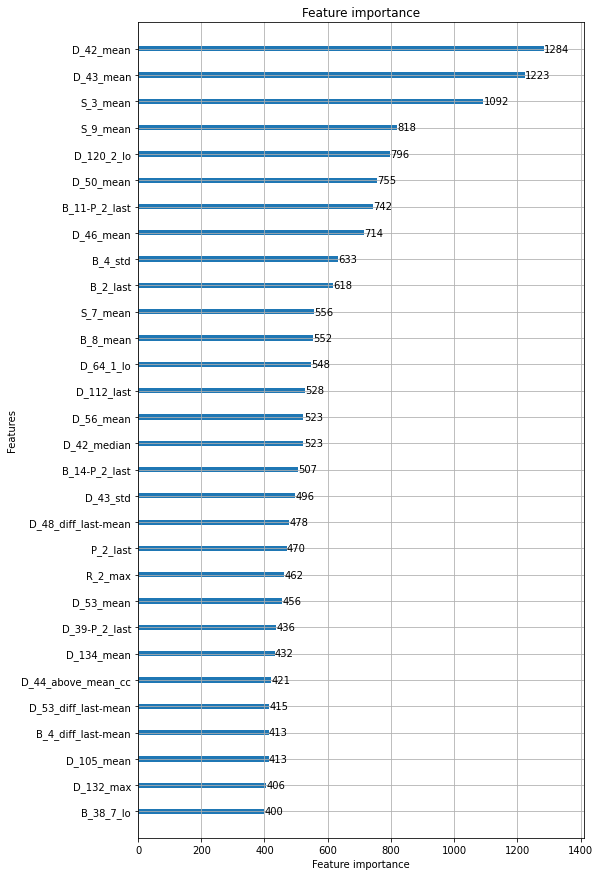

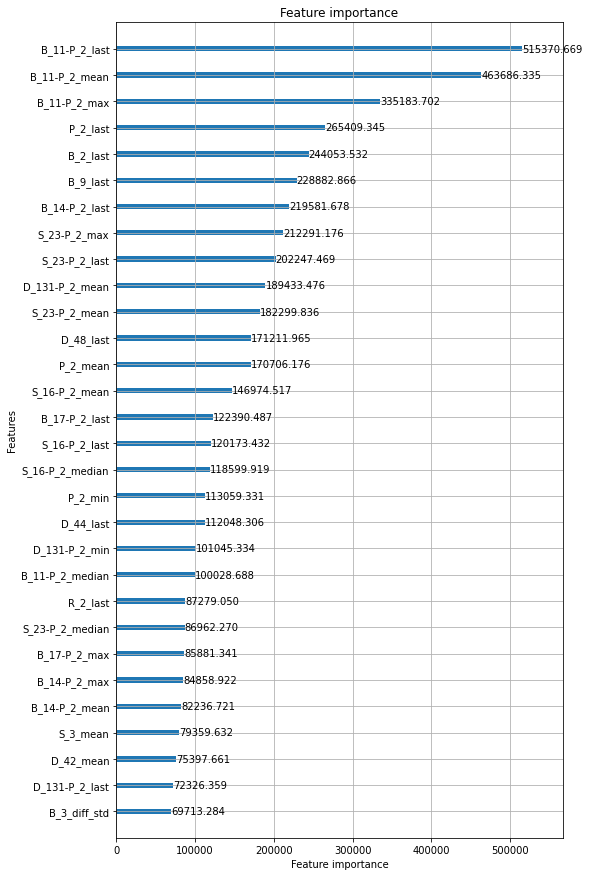

Training time: 212.1421305735906 min.
OOF recall_at4: 0.6700356818258323
OOF normalized_gini: 0.9258030746180662
OOF competition metric: 0.7979193782219492


CPU times: user 3d 8h 19s, sys: 2min 46s, total: 3d 8h 3min 5s
Wall time: 10h 35min 16s


In [12]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
        
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [13]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.669606,0.925766,0.797686
1,0.670701,0.925829,0.798265
2,0.670036,0.925803,0.797919



mean:


recall_at4    0.670114
gini          0.925799
metric        0.797957
dtype: float64


std:


recall_at4    0.000551
gini          0.000032
metric        0.000291
dtype: float64

In [14]:
del train, all_oof_dfs
gc.collect()

21

***
## make predictions and submit

In [15]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)       

In [16]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [17]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 2h 41min 4s, sys: 52.3 s, total: 2h 41min 56s
Wall time: 22min 24s


In [18]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.59 s, sys: 790 ms, total: 4.38 s
Wall time: 4.38 s


***